### U-Net with pytorch

* Drift removal: https://www.kaggle.com/cdeotte/one-feature-model-0-930/notebook
* Five Unet models (1f, 1s, 3, 5, 10).

In [1]:
import os
import gc
import sys
import cv2
import glob
import time
import signal
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import tensorboardX
from tqdm.notebook import tqdm

from collections import OrderedDict
from sklearn import model_selection

seed = 42
test_size = 0.2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
workspace = "./unet"

backbone = [1, 1, 1, 1]
encoder_channels = np.array([64, 128, 256, 512, 1024])*2
decoder_channels = np.array([512, 256, 128, 64])*2

fold = 0
time_step = 4000 # a continuous batch is 500000!
time_step_test = 10000
stride = 2 # for 4 times
batch_size = 8

TRAIN = True
PREDICT = True
ENSEMBLE = False

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = True


print(device)

cuda:0


In [2]:
# data loading 

df_train = pd.read_csv("../input/liverpool-ion-switching/train.csv")
df_test = pd.read_csv("../input/liverpool-ion-switching/test.csv")

In [3]:
# possible augmentations?
# https://github.com/iver56/audiomentations

def do_identity(image, label):
    return image, label

def do_flip(image, label):
    image = np.ascontiguousarray(np.flip(image, axis=1))
    label = np.ascontiguousarray(np.flip(label))
    return image, label

def train_augment(image, label):
    for op in np.random.choice([
        lambda image, label: do_identity(image, label),
        lambda image, label: do_flip(image, label),
    ], 1):
        image, label = op(image, label)
    
    return image, label

def valid_augment(image, label):
    return image, label

In [4]:
class IonDataset(Dataset):
    def __init__(self, data, labels=None, type='train', transform=None):
        self.data = data
        self.labels = labels
        self.type = type
        self.transform = transform
        
    def __getitem__(self, i):
        signal = self.data[i].astype(np.float32) # [1, time_step]
        if self.type == 'train':
            label = self.labels[i].astype(np.int64) # [time_step]
            if self.transform is not None:
                signal, label = self.transform(signal, label)
            return signal, label
        else:
            return signal
    
    def __len__(self):
        return len(self.data)

### The model

In [5]:
class SEModule(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, in_channels//reduction, kernel_size=1, padding=0)
        self.conv2 = nn.Conv1d(in_channels//reduction, in_channels, kernel_size=1, padding=0)
        
    def forward(self, x):
        # x: [B, C, H]
        s = F.adaptive_avg_pool1d(x, 1) # [B, C, 1]
        s = self.conv1(s) # [B, C//reduction, 1]
        s = F.relu(s, inplace=True)
        s = self.conv2(s) # [B, C, 1]
        x = x + torch.sigmoid(s)
        return x

class ConvBR1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, padding=0, dilation=1, stride=1, groups=1, is_activation=True):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, dilation=dilation, stride=stride, groups=groups, bias=False)
        self.bn = nn.BatchNorm1d(out_channels)
        self.is_activation = is_activation
        
        if is_activation:
            self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.bn(self.conv(x))
        if self.is_activation:
            x = self.relu(x)
        return x


class SENextBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, groups=32, reduction=16, pool=None, is_shortcut=False):
        super().__init__()
        mid_channels = out_channels // 2
        self.conv1 = ConvBR1d(in_channels, mid_channels, 1, 0, 1, )
        self.conv2 = ConvBR1d(mid_channels, mid_channels, 3, 1, 1, groups=groups)
        self.conv3 = ConvBR1d(mid_channels, out_channels, 1, 0, 1, is_activation=False)
        self.se = SEModule(out_channels, reduction)
        self.stride = stride
        self.is_shortcut = is_shortcut
        
        if is_shortcut:
            self.shortcut = ConvBR1d(in_channels, out_channels, 1, 0, 1, is_activation=False)
        if stride > 1:
            if pool == 'max':
                self.pool = nn.MaxPool1d(stride, stride)
            elif pool == 'avg':
                self.pool = nn.AvgPool1d(stride, stride)
    
    def forward(self, x):
        s = self.conv1(x)
        s = self.conv2(s)
        if self.stride > 1:
            s = self.pool(s)
        s = self.conv3(s)
        s = self.se(s)
        
        if self.is_shortcut:
            if self.stride > 1:
                x = F.avg_pool1d(x, self.stride, self.stride) # avg
            x = self.shortcut(x)
        
        x = x + s
        x = F.relu(x, inplace=True)
        
        return x


class Encoder(nn.Module):
    def __init__(self, num_features=1):
        super().__init__()
        self.block0 = nn.Sequential(
            ConvBR1d(num_features, encoder_channels[0], kernel_size=5, stride=1, padding=2),
            ConvBR1d(encoder_channels[0], encoder_channels[0], kernel_size=3, stride=1, padding=1),
            ConvBR1d(encoder_channels[0], encoder_channels[0], kernel_size=3, stride=1, padding=1),
        )
        self.block1 = nn.Sequential(
            SENextBottleneck(encoder_channels[0], encoder_channels[1], stride=stride, is_shortcut=True, pool='max'),
          *[SENextBottleneck(encoder_channels[1], encoder_channels[1], stride=1, is_shortcut=False) for i in range(backbone[0])]
        )
        self.block2 = nn.Sequential(
            SENextBottleneck(encoder_channels[1], encoder_channels[2], stride=stride, is_shortcut=True, pool='max'),
          *[SENextBottleneck(encoder_channels[2], encoder_channels[2], stride=1, is_shortcut=False) for i in range(backbone[1])]
        )
        self.block3 = nn.Sequential(
            SENextBottleneck(encoder_channels[2], encoder_channels[3], stride=stride, is_shortcut=True, pool='max'),
          *[SENextBottleneck(encoder_channels[3], encoder_channels[3], stride=1, is_shortcut=False) for i in range(backbone[2])]
        )
        self.block4 = nn.Sequential(
            SENextBottleneck(encoder_channels[3], encoder_channels[4], stride=stride, is_shortcut=True, pool='avg'),
          *[SENextBottleneck(encoder_channels[4], encoder_channels[4], stride=1, is_shortcut=False) for i in range(backbone[3])]
        )  
        
    def forward(self, x):
        x0 = self.block0(x) # [B, 64, L]
        x1 = self.block1(x0) # [B, 256, L//2]
        x2 = self.block2(x1) # [B, 512, L//4]
        x3 = self.block3(x2) # [B, 1024, L//8]
        x4 = self.block4(x3) # [B, 2048, L//16]
        
        return [x0, x1, x2, x3, x4]

class SCSEModule(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(in_channels, in_channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels // reduction, in_channels, 1),
            nn.Sigmoid(),
        )
        self.sSE = nn.Sequential(nn.Conv1d(in_channels, 1, 1), nn.Sigmoid())

    def forward(self, x):
        return x * self.cSE(x) + x * self.sSE(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.conv1 = ConvBR1d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = ConvBR1d(out_channels, out_channels, kernel_size=3, padding=1)
        # att
        #self.att1 = SCSEModule(in_channels + skip_channels)
        #self.att2 = SCSEModule(out_channels)
        
    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=stride, mode="linear", align_corners=True)
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
            #x = self.att1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        #x = self.att2(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.block4 = DecoderBlock(encoder_channels[-1], encoder_channels[-2], decoder_channels[0])
        self.block3 = DecoderBlock(decoder_channels[0], encoder_channels[-3], decoder_channels[1])
        self.block2 = DecoderBlock(decoder_channels[1], encoder_channels[-4], decoder_channels[2])
        self.block1 = DecoderBlock(decoder_channels[2], encoder_channels[-5], decoder_channels[3])

    def forward(self, xs):

        x = self.block4(xs[4], xs[3])
        x = self.block3(x, xs[2])
        x = self.block2(x, xs[1])
        x = self.block1(x, xs[0])
        
        return x
        
    
class Unet(nn.Module):
    def __init__(self, num_features=1, num_classes=11):
        super().__init__()
        self.num_features = num_features
        self.num_classes = num_classes
        self.encoder = Encoder(num_features=num_features)
        self.decoder = Decoder()
        self.segmentation_head = nn.Conv1d(decoder_channels[-1], num_classes, kernel_size=1, padding=0, stride=1)
    
    def forward(self, x):
        features = self.encoder(x)
        x = self.decoder(features)
        x = self.segmentation_head(x)
        return x


### Trainer and Predictor
Basically ignore them.

In [6]:
# trainer
class Logger:
    def __init__(self, workspace=None, flush=True, mute=False):
        self.workspace = workspace
        self.flush = flush
        self.mute = mute
        if workspace is not None:
            os.makedirs(workspace, exist_ok=True)
            self.log_file = os.path.join(workspace, "log.txt")
            self.fp = open(self.log_file, "a+")
        else:
            self.fp = None

    def __del__(self):
        if self.fp: 
            self.fp.close()

    def _print(self, text, use_pprint=False):
        if not self.mute:
            print(text) if not use_pprint else pprint(text)
        if self.fp:
            print(text, file=self.fp)
        if self.flush:
            sys.stdout.flush()

    def log(self, text, level=0):
        text = "\t"*level + text
        text.replace("\n", "\n"+"\t"*level)
        self._print(text)

    def log1(self, text):
        self.log(text, level=1)

    def info(self, text):
        text = "[INFO] " + text
        text.replace("\n", "\n"+"[INFO] ")
        self._print(text)

    def error(self, text):
        text = "[ERROR] " + text
        text.replace("\n", "\n"+"[ERROR] ")
        self._print(text)


class DelayedKeyboardInterrupt(object):
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = (sig, frame)
        print('SIGINT received. Delaying KeyboardInterrupt.')

    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received: 
            self.old_handler(*self.signal_received)


def fix_random_seed(seed=42, cudnn=False):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if cudnn:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


# from torch_summary
def summary(model, input_size, batch_size=-1, device="cuda", logger=None):
    # redirect to write in file
    if logger is not None:
        print = logger._print

    def register_hook(module):

        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)

            m_key = "%s-%i" % (class_name, module_idx + 1)
            summary[m_key] = OrderedDict()
            summary[m_key]["input_shape"] = list(input[0].size())
            summary[m_key]["input_shape"][0] = batch_size
            if isinstance(output, (list, tuple)):
                summary[m_key]["output_shape"] = [
                    [-1] + list(o.size())[1:] for o in output
                ]
            else:
                summary[m_key]["output_shape"] = list(output.size())
                summary[m_key]["output_shape"][0] = batch_size

            params = 0
            if hasattr(module, "weight") and hasattr(module.weight, "size"):
                params += torch.prod(torch.LongTensor(list(module.weight.size())))
                summary[m_key]["trainable"] = module.weight.requires_grad
            if hasattr(module, "bias") and hasattr(module.bias, "size"):
                params += torch.prod(torch.LongTensor(list(module.bias.size())))
            summary[m_key]["nb_params"] = params

        if (
            not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
            and not (module == model)
        ):
            hooks.append(module.register_forward_hook(hook))

    device = device.lower()
    assert device in [
        "cuda",
        "cpu",
    ], "Input device is not valid, please specify 'cuda' or 'cpu'"

    if device == "cuda" and torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    # multiple inputs to the network
    if isinstance(input_size, tuple):
        input_size = [input_size]

    # batch_size of 2 for batchnorm
    x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
    # print(type(x[0]))

    # create properties
    summary = OrderedDict()
    hooks = []

    # register hook
    model.apply(register_hook)

    # make a forward pass
    # print(x.shape)
    model(*x)

    # remove these hooks
    for h in hooks:
        h.remove()

    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
    print(line_new)
    print("================================================================")
    total_params = 0
    total_output = 0
    trainable_params = 0
    for layer in summary:
        # input_shape, output_shape, trainable, nb_params
        line_new = "{:>20}  {:>25} {:>15}".format(
            layer,
            str(summary[layer]["output_shape"]),
            "{0:,}".format(summary[layer]["nb_params"]),
        )
        total_params += summary[layer]["nb_params"]
        total_output += np.prod(summary[layer]["output_shape"])
        if "trainable" in summary[layer]:
            if summary[layer]["trainable"] == True:
                trainable_params += summary[layer]["nb_params"]
        print(line_new)

    # assume 4 bytes/number (float on cuda).
    total_input_size = abs(np.prod(input_size) * batch_size * 4. / (1024 ** 2.))
    total_output_size = abs(2. * total_output * 4. / (1024 ** 2.))  # x2 for gradients
    total_params_size = abs(total_params.numpy() * 4. / (1024 ** 2.))
    total_size = total_params_size + total_output_size + total_input_size

    print("================================================================")
    print("Total params: {0:,}".format(total_params))
    print("Trainable params: {0:,}".format(trainable_params))
    print("Non-trainable params: {0:,}".format(total_params - trainable_params))
    print("----------------------------------------------------------------")
    print("Input size (MB): %0.2f" % total_input_size)
    print("Forward/backward pass size (MB): %0.2f" % total_output_size)
    print("Params size (MB): %0.2f" % total_params_size)
    print("Estimated Total Size (MB): %0.2f" % total_size)
    print("----------------------------------------------------------------")
    # return summary
        

class Trainer(object):
    """Base trainer class. 
    """
    def __init__(self,
                 device,
                 workspace,
                 model, 
                 optimizer, 
                 lr_scheduler, 
                 objective, 
                 dataloaders,
                 metrics=[],
                 model_name=None,
                 input_shape=None,
                 use_checkpoint="latest",
                 use_tensorboardX=True,
                 max_keep_ckpt=1,
                 eval_interval=1,
                 report_step_interval=300,
                 restart=False,
                 ):
        
        self.device = device
        self.workspace_path = workspace
        self.model = model
        self.model_name = model_name
        self.restart = restart
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.objective = objective
        self.dataloaders = dataloaders
        self.metrics = metrics
        self.log = Logger(workspace)
        self.use_checkpoint = use_checkpoint
        self.max_keep_ckpt = max_keep_ckpt
        self.eval_interval = eval_interval
        self.report_step_interval = report_step_interval
        self.time_stamp = time.strftime("%Y-%m-%d_%H-%M-%S")
        self.log.info(f'Time stamp is {self.time_stamp}')
        self.use_tensorboardX = use_tensorboardX
        self.writer = None

        self.model.to(self.device)

        if input_shape is not None:
            summary(self.model, input_shape, logger=self.log)

        self.log.info(f'Number of model parameters: {sum([p.numel() for p in model.parameters() if p.requires_grad])}')

        self.epoch = 1
        self.global_step = 0
        self.local_step = 0
        self.stats = {
            "EvalResults": [],
            "Checkpoints": [],
            "BestResult": None,
            }

        if self.workspace_path is not None:
            os.makedirs(self.workspace_path, exist_ok=True)
            if self.use_checkpoint == "latest":
                self.log.info("Loading latest checkpoint ...")
                self.load_checkpoint()
            elif self.use_checkpoint == "scratch":
                self.log.info("Train from scratch")
            elif self.use_checkpoint == "best":
                self.log.info("Loading best checkpoint ...")
                model_name = type(self.model).__name__
                best_path = f"{self.workspace_path}/{model_name}_best.pth.tar"
                self.load_checkpoint(best_path)
            else: # path to ckpt
                self.log.info(f"Loading checkpoint {self.use_checkpoint} ...")
                self.load_checkpoint(self.use_checkpoint)
    
    ### ------------------------------
    
    def train_step(self, data):
        image, mask = data

        output = self.model(image)
        loss = self.objective(output, mask)
        pred = F.softmax(output, 1).detach().cpu().numpy().argmax(axis=1)

        return pred, mask, loss 

    def eval_step(self, data):
        image, mask = data
        
        # tta
        output = (self.model(image) + torch.flip(self.model(torch.flip(image, dims=[2])), dims=[2]))/2
        #output = self.model(image)

        loss = self.objective(output, mask)
        pred = F.softmax(output, 1).detach().cpu().numpy().argmax(axis=1)

        return pred, mask, loss 

    ### ------------------------------

    def train(self, max_epochs=None):
        """
        do the training process for max_epochs.
        """
        if max_epochs is None:
            max_epochs = self.conf.max_epochs
        
        
        if self.use_tensorboardX:
            logdir = os.path.join(self.workspace_path, "run")
            self.writer = tensorboardX.SummaryWriter(logdir)
        
        for epoch in range(self.epoch, max_epochs+1):
            self.epoch = epoch

            if self.optimizer.param_groups[0]['lr'] < 1e-8:
                self.log.info("Early stopping.")
            
            self.train_one_epoch()

            if self.epoch % self.eval_interval == 0:
                self.evaluate_one_epoch()

                if self.workspace_path is not None:
                    self.save_checkpoint()
                    
        if self.use_tensorboardX:
            self.writer.close()

        self.log.info("Finished Training.")

    def evaluate(self):
        self.log.info(f"Evaluate at best epoch...")

        # load model
        model_name = type(self.model).__name__
        best_path = f"{self.workspace_path}/{model_name}_best.pth.tar"
        if not os.path.exists(best_path):
            self.log.error(f"Best checkpoint not found! {best_path}, not loading anything.")
        else:
            self.load_checkpoint(best_path)

        self.use_tensorboardX = False
        self.evaluate_one_epoch()
        
    def get_time(self):
        if torch.cuda.is_available(): 
            torch.cuda.synchronize()
        return time.time()

    def prepare_data(self, data):
        """ ToTensor for various data format """
        if isinstance(data, list) or isinstance(data, tuple):
            for i, v in enumerate(data):
                if isinstance(v, np.ndarray):
                    data[i] = torch.from_numpy(v).to(self.device)
                if torch.is_tensor(v):
                    data[i] = v.to(self.device)
        elif isinstance(data, dict):
            for k, v in data.items():
                if isinstance(v, np.ndarray):
                    data[k] = torch.from_numpy(v).to(self.device)
                if torch.is_tensor(v):
                    data[k] = v.to(self.device)
        elif isinstance(data, np.ndarray):
            data = torch.from_numpy(data).to(self.device)
        else: # is_tensor
            data = data.to(self.device)

        return data

    
    def train_one_epoch(self):
        self.log.log(f"==> Start Training Epoch {self.epoch}, lr={self.optimizer.param_groups[0]['lr']} ...")

        for metric in self.metrics:
            metric.clear()
        total_loss = []
        self.model.train()

        pbar = tqdm(self.dataloaders["train"])

        self.local_step = 0
        epoch_start_time = self.get_time()                     
                     
        for data in pbar:
            start_time = self.get_time()
            self.local_step += 1
            self.global_step += 1
            
            data = self.prepare_data(data)

            preds, truths, loss = self.train_step(data)
            
            loss.backward()
            
            self.optimizer.step()
            self.optimizer.zero_grad()

            for metric in self.metrics:
                metric.update(preds, truths)

            total_loss.append(loss.item())
            total_time = self.get_time() - start_time

            if self.report_step_interval > 0 and self.local_step % self.report_step_interval == 0:
                self.log.log1(f"step={self.epoch}/{self.local_step}, loss={loss.item():.4f}, time={total_time:.2f}")
                for metric in self.metrics:
                    self.log.log1(metric.report())

            if self.use_tensorboardX:
                self.writer.add_scalar(f"train{self.model_name}/loss", loss.item(), self.global_step)

        if self.report_step_interval < 0:
            for metric in self.metrics:
                self.log.log1(metric.report())
                metric.clear()

        epoch_end_time = self.get_time()
        average_loss = np.mean(total_loss)

        self.log.log(f"==> Finished Epoch {self.epoch}, average_loss={average_loss:.4f}, time={epoch_end_time-epoch_start_time:.4f}")


    def evaluate_one_epoch(self):
        self.log.log(f"++> Evaluate at epoch {self.epoch} ...")

        for metric in self.metrics:
            metric.clear()
        self.model.eval()

        pbar = tqdm(self.dataloaders['valid'])

        epoch_start_time = self.get_time()
        total_loss = []

        with torch.no_grad():
            self.local_step = 0
            start_time = self.get_time()
            
            for data in pbar:    
                self.local_step += 1
                
                data = self.prepare_data(data)
                preds, truths, loss = self.eval_step(data)
                total_loss.append(loss.item())
                
                for metric in self.metrics:
                    metric.update(preds, truths)

            total_time = self.get_time() - start_time
            self.log.log1(f"total_time={total_time:.2f}")

            average_loss = np.mean(total_loss)
            
            for metric in self.metrics:
                self.log.log1(metric.report())
                if self.use_tensorboardX:
                    metric.write(self.writer, self.epoch, prefix=f"evaluate{self.model_name}")
                metric.clear()
            
            if self.use_tensorboardX:
                self.writer.add_scalar(f"evaluate{self.model_name}/loss", average_loss, self.epoch)
            
            self.stats["EvalResults"].append(self.metrics[0].measure())

        # monitor val loss!!!
        self.lr_scheduler.step(average_loss)

        epoch_end_time = self.get_time()
        self.log.log(f"++> Evaluate Finished. time={epoch_end_time-epoch_start_time:.4f}, loss={average_loss:.4f}")

    def save_checkpoint(self):
        with DelayedKeyboardInterrupt():
            model_name = type(self.model).__name__ if self.model_name is None else self.model_name
            file_path = f"{self.workspace_path}/{model_name}_ep{self.epoch:04d}.pth.tar"
            best_path = f"{self.workspace_path}/{model_name}_best.pth.tar"
            os.makedirs(self.workspace_path, exist_ok=True)

            self.stats["Checkpoints"].append(file_path)

            if len(self.stats["Checkpoints"]) > self.max_keep_ckpt:
                old_ckpt = self.stats["Checkpoints"].pop(0)
                if os.path.exists(old_ckpt):
                    os.remove(old_ckpt)
                    self.log.info(f"Removed old checkpoint {old_ckpt}")

            state = {
                'epoch': self.epoch,
                'global_step': self.global_step,
                'model_name': model_name,
                'model': self.model.state_dict(),
                'optimizer' : self.optimizer.state_dict(),
                'lr_scheduler': self.lr_scheduler.state_dict(),
                'stats' : self.stats,
            }
            
            torch.save(state, file_path)
            self.log.info(f"Saved checkpoint {self.epoch} successfully.")
            
            if self.stats["EvalResults"] is not None:
                ### better function
                if self.stats["BestResult"] is None or self.stats["EvalResults"][-1] > self.stats["BestResult"]:
                    self.stats["BestResult"] = self.stats["EvalResults"][-1]
                    torch.save(state, best_path)
                    self.log.info(f"Saved Best checkpoint.")
            

    def load_checkpoint(self, checkpoint=None):

        model_name = self.model_name if self.model_name is not None else type(self.model).__name__
        
        if checkpoint is None:
            # Load most recent checkpoint            
            checkpoint_list = sorted(glob.glob(f'{self.workspace_path}/{model_name}_ep*.pth.tar'))
            if checkpoint_list:
                checkpoint_path = checkpoint_list[-1]
            else:
                self.log.info("No checkpoint found, model randomly initialized.")
                return False
        elif isinstance(checkpoint, int):
            # Checkpoint is the epoch number
            checkpoint_path = f'{self.workspace_path}/{model_name}_ep{checkpoint:04d}.pth.tar'
        elif isinstance(checkpoint, str):
            # checkpoint is the path
            checkpoint_path = os.path.expanduser(checkpoint)
        else:
            self.log.error("load_checkpoint: Invalid argument")
            raise TypeError

        checkpoint_dict = torch.load(checkpoint_path)

        self.model.load_state_dict(checkpoint_dict['model'])
        if not self.restart:
            self.log.info("Loading epoch and other status...")
            self.epoch = checkpoint_dict['epoch'] + 1
            self.global_step = checkpoint_dict['global_step']
            self.optimizer.load_state_dict(checkpoint_dict['optimizer'])
            self.lr_scheduler.load_state_dict(checkpoint_dict['lr_scheduler'])
            self.lr_scheduler.last_epoch = checkpoint_dict['epoch'] 
            self.stats = checkpoint_dict['stats']
        else:
            self.log.info("Only loading model parameters.")
        
        self.log.info("Checkpoint Loaded Successfully.")
        return True


class Predictor(object):
    def __init__(self, device, models):
        self.device = device
        self.models = models
        self.log = Logger()
        self.time_stamp = time.strftime("%Y-%m-%d_%H-%M-%S")
        self.log.info(f'Time stamp is {self.time_stamp}')
        for model in self.models:
            model.to(self.device)
            
    def predict_step(self, data):
        image = data

        outputs = []
        for model in self.models:

            # tta: flip
            output = (model(image) + torch.flip(model(torch.flip(image, dims=[2])), dims=[2]))/2
            #output = model(image)

            outputs.append(F.softmax(output, 1))
            
        pred = torch.mean(torch.stack(outputs, 0), 0).detach().cpu().numpy()
        pred = pred.argmax(axis=1).astype(np.int64) # [B, L]
        
        return pred

    def predict(self, dataloader):
        self.log.log(f"++> Predict start")
        # predict
        for model in self.models:
            model.eval()
        pbar = tqdm(dataloader)
        res = []
        epoch_start_time = self.get_time()
        with torch.no_grad():
            self.local_step = 0
            start_time = self.get_time()
            for data in pbar:    
                self.local_step += 1
                data = self.prepare_data(data)
                pred = self.predict_step(data)
                res.extend(pred.reshape(-1))
                
            total_time = self.get_time() - start_time
            self.log.log1(f"total_time={total_time:.2f}")
        epoch_end_time = self.get_time()
        self.log.log(f"++> Predict Finished. time={epoch_end_time-epoch_start_time:.4f}")
        
        return res
        
    def get_time(self):
        if torch.cuda.is_available(): 
            torch.cuda.synchronize()
        return time.time()

    def prepare_data(self, data):
        """ ToTensor for various data format """
        if isinstance(data, list) or isinstance(data, tuple):
            for i, v in enumerate(data):
                if isinstance(v, np.ndarray):
                    data[i] = torch.from_numpy(v).to(self.device)
                if torch.is_tensor(v):
                    data[i] = v.to(self.device)
        elif isinstance(data, dict):
            for k, v in data.items():
                if isinstance(v, np.ndarray):
                    data[k] = torch.from_numpy(v).to(self.device)
                if torch.is_tensor(v):
                    data[k] = v.to(self.device)
        elif isinstance(data, np.ndarray):
            data = torch.from_numpy(data).to(self.device)
        else: # is_tensor
            data = data.to(self.device)
        return data

    def load_checkpoint(self, checkpoint_path, idx=0):
        checkpoint = torch.load(checkpoint_path)
        self.models[idx].load_state_dict(checkpoint['model'])
        self.log.info("Checkpoint Loaded Successfully.")
        return True

In [7]:
class ClassificationMeter:
    """ statistics for classification """
    def __init__(self, nCls, eps=1e-5, names=None):
        self.nCls = nCls
        self.names = names
        self.eps = eps
        self.N = 0
        self.table = np.zeros((self.nCls, 4), dtype=np.int32)
        self._measure = None

    def clear(self):
        self.N = 0
        self.table = np.zeros((self.nCls, 4), dtype=np.int32)

    def prepare_inputs(self, outputs, truths):
        """
        outputs and truths are pytorch tensors or numpy ndarrays.
        """
        if torch.is_tensor(outputs):
            outputs = outputs.detach().cpu().numpy()
        if torch.is_tensor(truths):
            truths = truths.detach().cpu().numpy()
        
        return outputs, truths

    def update(self, preds, truths):
        preds, truths = self.prepare_inputs(preds, truths)
        self.N += np.prod(truths.shape)
        for Cls in range(self.nCls):
            true_positive = np.count_nonzero(np.bitwise_and(preds == Cls, truths == Cls))
            true_negative = np.count_nonzero(np.bitwise_and(preds != Cls, truths != Cls))
            false_positive = np.count_nonzero(np.bitwise_and(preds == Cls, truths != Cls))
            false_negative = np.count_nonzero(np.bitwise_and(preds != Cls, truths == Cls))
            self.table[Cls] += [true_positive, true_negative, false_positive, false_negative]

    # call after report() !
    def measure(self):
        return self._measure

    def better(self, A, B):
        return A > B

    def write(self, writer, global_step, prefix=""):
        writer.add_scalar(os.path.join(prefix, "Accuracy"), self.measure(), global_step)

    def report(self, each_class=False):
        precisions = []
        recalls = []
        f1s = []
        for Cls in range(self.nCls):
            recall = self.table[Cls,0] / (self.table[Cls,0] + self.table[Cls,3] + self.eps) # TP / (TP + FN)
            precision = self.table[Cls,0] / (self.table[Cls,0] + self.table[Cls,2] + self.eps) # TP / (TP + FP)
            f1 = 2 * precision * recall / (precision + recall + self.eps)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
            
        total_TP = np.sum(self.table[:, 0]) # all true positives 
        
        accuracy = total_TP/self.N
        accuracy_mean_class = np.mean(precisions)
        
        macro_f1 = np.mean(f1s)
        
        # use macro_f1 to measure performance
        self._measure = macro_f1
        
        text =    f"Macro      F1       = {macro_f1:.4f}\n"
        text += f"\tOverall    Accuracy = {accuracy:.4f}({total_TP}/{self.N})\n"
        text += f"\tMean-class Accuracy = {accuracy_mean_class:.4f}\n"
        
        if each_class:
            for Cls in range(self.nCls):
                #if precisions[Cls] != 0 or recalls[Cls] != 0:
                text += f"\tClass {str(Cls)+'('+self.names[Cls]+')' if self.names is not None else Cls}: precision = {precisions[Cls]:.3f} recall = {recalls[Cls]:.3f}\n"

        return text

In [8]:
def five_type_remove_drift(train):
    # CLEAN TRAIN BATCH 2
    a=500000; b=600000 
    train.loc[train.index[a:b],'signal'] = train.signal[a:b].values - 3*(train.time.values[a:b] - 50)/10.
    def f(x,low,high,mid): 
        return -((-low+high)/625)*(x-mid)**2+high -low
    # CLEAN TRAIN BATCH 7
    batch = 7; a = 500000*(batch-1); b = 500000*batch
    train.loc[train.index[a:b],'signal'] = train.signal.values[a:b] - f(train.time[a:b].values,-1.817,3.186,325)
    # CLEAN TRAIN BATCH 8
    batch = 8; a = 500000*(batch-1); b = 500000*batch
    train.loc[train.index[a:b],'signal'] = train.signal.values[a:b] - f(train.time[a:b].values,-0.094,4.936,375)
    # CLEAN TRAIN BATCH 9
    batch = 9; a = 500000*(batch-1); b = 500000*batch
    train.loc[train.index[a:b],'signal'] = train.signal.values[a:b] - f(train.time[a:b].values,1.715,6.689,425)
    # CLEAN TRAIN BATCH 10
    batch = 10; a = 500000*(batch-1); b = 500000*batch
    train.loc[train.index[a:b],'signal'] = train.signal.values[a:b] - f(train.time[a:b].values,3.361,8.45,475)
    return train

In [9]:
if TRAIN:
    df_train = five_type_remove_drift(df_train)
    # 1 slow
    batch = 1; a = 500000*(batch-1); b = 500000*batch
    batch = 2; c = 500000*(batch-1); d = 500000*batch
    X_train_1s = np.concatenate([df_train.signal.values[a:b],df_train.signal.values[c:d]]).reshape((-1,1))
    y_train_1s = np.concatenate([df_train.open_channels.values[a:b],df_train.open_channels.values[c:d]]).reshape((-1,1))
    # 1 fast
    batch = 3; a = 500000*(batch-1); b = 500000*batch
    batch = 7; c = 500000*(batch-1); d = 500000*batch
    X_train_1f = np.concatenate([df_train.signal.values[a:b],df_train.signal.values[c:d]]).reshape((-1,1))
    y_train_1f = np.concatenate([df_train.open_channels.values[a:b],df_train.open_channels.values[c:d]]).reshape((-1,1))
    # 3
    batch = 4; a = 500000*(batch-1); b = 500000*batch
    batch = 8; c = 500000*(batch-1); d = 500000*batch
    X_train_3 = np.concatenate([df_train.signal.values[a:b],df_train.signal.values[c:d]]).reshape((-1,1))
    y_train_3 = np.concatenate([df_train.open_channels.values[a:b],df_train.open_channels.values[c:d]]).reshape((-1,1))
    # 5
    batch = 6; a = 500000*(batch-1); b = 500000*batch
    batch = 9; c = 500000*(batch-1); d = 500000*batch
    X_train_5 = np.concatenate([df_train.signal.values[a:b],df_train.signal.values[c:d]]).reshape((-1,1))
    y_train_5 = np.concatenate([df_train.open_channels.values[a:b],df_train.open_channels.values[c:d]]).reshape((-1,1))
    # 10
    batch = 5; a = 500000*(batch-1); b = 500000*batch
    batch = 10; c = 500000*(batch-1); d = 500000*batch
    X_train_10 = np.concatenate([df_train.signal.values[a:b],df_train.signal.values[c:d]]).reshape((-1,1))
    y_train_10 = np.concatenate([df_train.open_channels.values[a:b],df_train.open_channels.values[c:d]]).reshape((-1,1))

    for X, y, num_classes, model_name, max_epoch in zip(
            [X_train_1s, X_train_1f, X_train_3, X_train_5, X_train_10], 
            [y_train_1s, y_train_1f, y_train_3, y_train_5, y_train_10],
            np.array([1, 1, 3, 5, 10])+1,
            ['1s', '1f', '3', '5', '10'],
            [30, 30, 60, 60, 120],
        ):

        X = X.reshape(-1, 1, time_step)
        y = y.reshape(-1, time_step)

        # split
        idx = np.arange(X.shape[0])
        kf = model_selection.KFold(5, shuffle=True, random_state=seed)
        train_idx, val_idx = list(kf.split(idx))[fold]
        #train_idx, val_idx = model_selection.train_test_split(idx, random_state=seed, test_size=test_size)
        
        print("model_name:", model_name)
        print("train dataset shape:", X[train_idx].shape, y[train_idx].shape)

        train_dataset = IonDataset(X[train_idx], y[train_idx], 'train', train_augment)
        valid_dataset = IonDataset(X[val_idx], y[val_idx], 'train', valid_augment)

        loaders = {
            'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
            'valid': DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
        }
        
        model = Unet(num_classes=num_classes)

        loss_function = nn.CrossEntropyLoss()
        
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
        #optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay=1e-5)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1, min_lr=1e-8)
        
        metrics = [ClassificationMeter(num_classes),]
        
        trainer = Trainer(device, workspace, model, optimizer, scheduler, loss_function, loaders, metrics,
                          model_name=model_name,
                          report_step_interval=-1,
                          #input_shape=(1, time_step),
                         )
        
        trainer.train(max_epoch)



model_name: 1s
train dataset shape: (200, 1, 4000) (200, 4000)
[INFO] Time stamp is 2020-03-21_15-22-02
[INFO] Number of model parameters: 31053410
[INFO] Loading latest checkpoint ...
[INFO] No checkpoint found, model randomly initialized.
==> Start Training Epoch 1, lr=0.001 ...



	Macro      F1       = 0.7601
	Overall    Accuracy = 0.9432(754548/800000)
	Mean-class Accuracy = 0.6925

==> Finished Epoch 1, average_loss=0.2274, time=7.2182
++> Evaluate at epoch 1 ...



	total_time=1.07
	Macro      F1       = 0.8191
	Overall    Accuracy = 0.9841(196830/200000)
	Mean-class Accuracy = 0.9914

++> Evaluate Finished. time=1.0690, loss=0.0991
[INFO] Saved checkpoint 1 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 2, lr=0.001 ...



	Macro      F1       = 0.9908
	Overall    Accuracy = 0.9987(798969/800000)
	Mean-class Accuracy = 0.9910

==> Finished Epoch 2, average_loss=0.0388, time=6.3393
++> Evaluate at epoch 2 ...



	total_time=1.07
	Macro      F1       = 0.9872
	Overall    Accuracy = 0.9985(199699/200000)
	Mean-class Accuracy = 0.9885

++> Evaluate Finished. time=1.0674, loss=0.0301
[INFO] Removed old checkpoint ./unet/1s_ep0001.pth.tar
[INFO] Saved checkpoint 2 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 3, lr=0.001 ...



	Macro      F1       = 0.9902
	Overall    Accuracy = 0.9986(798905/800000)
	Mean-class Accuracy = 0.9902

==> Finished Epoch 3, average_loss=0.0200, time=6.3461
++> Evaluate at epoch 3 ...



	total_time=1.07
	Macro      F1       = 0.9955
	Overall    Accuracy = 0.9995(199894/200000)
	Mean-class Accuracy = 0.9957

++> Evaluate Finished. time=1.0690, loss=0.0138
[INFO] Removed old checkpoint ./unet/1s_ep0002.pth.tar
[INFO] Saved checkpoint 3 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 4, lr=0.001 ...



	Macro      F1       = 0.9954
	Overall    Accuracy = 0.9994(799481/800000)
	Mean-class Accuracy = 0.9951

==> Finished Epoch 4, average_loss=0.0116, time=6.3698
++> Evaluate at epoch 4 ...



	total_time=1.06
	Macro      F1       = 0.9973
	Overall    Accuracy = 0.9997(199937/200000)
	Mean-class Accuracy = 0.9979

++> Evaluate Finished. time=1.0672, loss=0.0085
[INFO] Removed old checkpoint ./unet/1s_ep0003.pth.tar
[INFO] Saved checkpoint 4 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 5, lr=0.001 ...



	Macro      F1       = 0.9964
	Overall    Accuracy = 0.9995(799592/800000)
	Mean-class Accuracy = 0.9961

==> Finished Epoch 5, average_loss=0.0082, time=6.4026
++> Evaluate at epoch 5 ...



	total_time=1.07
	Macro      F1       = 0.9970
	Overall    Accuracy = 0.9996(199929/200000)
	Mean-class Accuracy = 0.9978

++> Evaluate Finished. time=1.0689, loss=0.0072
[INFO] Removed old checkpoint ./unet/1s_ep0004.pth.tar
[INFO] Saved checkpoint 5 successfully.
==> Start Training Epoch 6, lr=0.001 ...



	Macro      F1       = 0.9965
	Overall    Accuracy = 0.9995(799607/800000)
	Mean-class Accuracy = 0.9967

==> Finished Epoch 6, average_loss=0.0064, time=6.4347
++> Evaluate at epoch 6 ...



	total_time=1.07
	Macro      F1       = 0.9971
	Overall    Accuracy = 0.9997(199932/200000)
	Mean-class Accuracy = 0.9985

++> Evaluate Finished. time=1.0688, loss=0.0055
[INFO] Removed old checkpoint ./unet/1s_ep0005.pth.tar
[INFO] Saved checkpoint 6 successfully.
==> Start Training Epoch 7, lr=0.001 ...



	Macro      F1       = 0.9966
	Overall    Accuracy = 0.9995(799617/800000)
	Mean-class Accuracy = 0.9963

==> Finished Epoch 7, average_loss=0.0052, time=6.3573
++> Evaluate at epoch 7 ...



	total_time=1.06
	Macro      F1       = 0.9972
	Overall    Accuracy = 0.9997(199934/200000)
	Mean-class Accuracy = 0.9970

++> Evaluate Finished. time=1.0579, loss=0.0042
[INFO] Removed old checkpoint ./unet/1s_ep0006.pth.tar
[INFO] Saved checkpoint 7 successfully.
==> Start Training Epoch 8, lr=0.001 ...



	Macro      F1       = 0.9967
	Overall    Accuracy = 0.9995(799634/800000)
	Mean-class Accuracy = 0.9967

==> Finished Epoch 8, average_loss=0.0044, time=6.3569
++> Evaluate at epoch 8 ...



	total_time=1.05
	Macro      F1       = 0.9973
	Overall    Accuracy = 0.9997(199936/200000)
	Mean-class Accuracy = 0.9970

++> Evaluate Finished. time=1.0552, loss=0.0040
[INFO] Removed old checkpoint ./unet/1s_ep0007.pth.tar
[INFO] Saved checkpoint 8 successfully.
==> Start Training Epoch 9, lr=0.001 ...



	Macro      F1       = 0.9968
	Overall    Accuracy = 0.9996(799643/800000)
	Mean-class Accuracy = 0.9966

==> Finished Epoch 9, average_loss=0.0038, time=6.3526
++> Evaluate at epoch 9 ...



	total_time=1.07
	Macro      F1       = 0.9971
	Overall    Accuracy = 0.9997(199932/200000)
	Mean-class Accuracy = 0.9977

++> Evaluate Finished. time=1.0695, loss=0.0034
[INFO] Removed old checkpoint ./unet/1s_ep0008.pth.tar
[INFO] Saved checkpoint 9 successfully.
==> Start Training Epoch 10, lr=0.001 ...



	Macro      F1       = 0.9968
	Overall    Accuracy = 0.9996(799644/800000)
	Mean-class Accuracy = 0.9968

==> Finished Epoch 10, average_loss=0.0035, time=6.3299
++> Evaluate at epoch 10 ...



	total_time=1.06
	Macro      F1       = 0.9966
	Overall    Accuracy = 0.9996(199919/200000)
	Mean-class Accuracy = 0.9950

++> Evaluate Finished. time=1.0665, loss=0.0030
[INFO] Removed old checkpoint ./unet/1s_ep0009.pth.tar
[INFO] Saved checkpoint 10 successfully.
==> Start Training Epoch 11, lr=0.001 ...



	Macro      F1       = 0.9968
	Overall    Accuracy = 0.9995(799639/800000)
	Mean-class Accuracy = 0.9966

==> Finished Epoch 11, average_loss=0.0032, time=6.3538
++> Evaluate at epoch 11 ...



	total_time=1.07
	Macro      F1       = 0.9970
	Overall    Accuracy = 0.9996(199929/200000)
	Mean-class Accuracy = 0.9985

++> Evaluate Finished. time=1.0755, loss=0.0029
[INFO] Removed old checkpoint ./unet/1s_ep0010.pth.tar
[INFO] Saved checkpoint 11 successfully.
==> Start Training Epoch 12, lr=0.001 ...



	Macro      F1       = 0.9969
	Overall    Accuracy = 0.9996(799655/800000)
	Mean-class Accuracy = 0.9968

==> Finished Epoch 12, average_loss=0.0029, time=6.5046
++> Evaluate at epoch 12 ...



	total_time=1.20
	Macro      F1       = 0.9976
	Overall    Accuracy = 0.9997(199943/200000)
	Mean-class Accuracy = 0.9984

++> Evaluate Finished. time=1.2027, loss=0.0026
[INFO] Removed old checkpoint ./unet/1s_ep0011.pth.tar
[INFO] Saved checkpoint 12 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 13, lr=0.001 ...



	Macro      F1       = 0.9973
	Overall    Accuracy = 0.9996(799700/800000)
	Mean-class Accuracy = 0.9970

==> Finished Epoch 13, average_loss=0.0025, time=6.3491
++> Evaluate at epoch 13 ...



	total_time=1.07
	Macro      F1       = 0.9974
	Overall    Accuracy = 0.9997(199939/200000)
	Mean-class Accuracy = 0.9977

++> Evaluate Finished. time=1.0710, loss=0.0022
[INFO] Removed old checkpoint ./unet/1s_ep0012.pth.tar
[INFO] Saved checkpoint 13 successfully.
==> Start Training Epoch 14, lr=0.001 ...



	Macro      F1       = 0.9974
	Overall    Accuracy = 0.9996(799708/800000)
	Mean-class Accuracy = 0.9973

==> Finished Epoch 14, average_loss=0.0023, time=6.3288
++> Evaluate at epoch 14 ...



	total_time=1.06
	Macro      F1       = 0.9971
	Overall    Accuracy = 0.9997(199932/200000)
	Mean-class Accuracy = 0.9975

++> Evaluate Finished. time=1.0671, loss=0.0022
[INFO] Removed old checkpoint ./unet/1s_ep0013.pth.tar
[INFO] Saved checkpoint 14 successfully.
==> Start Training Epoch 15, lr=0.001 ...



	Macro      F1       = 0.9926
	Overall    Accuracy = 0.9990(799166/800000)
	Mean-class Accuracy = 0.9911

==> Finished Epoch 15, average_loss=0.0047, time=6.3309
++> Evaluate at epoch 15 ...



	total_time=1.06
	Macro      F1       = 0.8495
	Overall    Accuracy = 0.9755(195091/200000)
	Mean-class Accuracy = 0.7763

++> Evaluate Finished. time=1.0615, loss=0.5241
[INFO] Removed old checkpoint ./unet/1s_ep0014.pth.tar
[INFO] Saved checkpoint 15 successfully.
==> Start Training Epoch 16, lr=0.001 ...



	Macro      F1       = 0.9931
	Overall    Accuracy = 0.9990(799219/800000)
	Mean-class Accuracy = 0.9918

==> Finished Epoch 16, average_loss=0.0043, time=6.3392
++> Evaluate at epoch 16 ...



	total_time=1.07
	Macro      F1       = 0.9949
	Overall    Accuracy = 0.9994(199881/200000)
	Mean-class Accuracy = 0.9990

++> Evaluate Finished. time=1.0693, loss=0.0034
[INFO] Removed old checkpoint ./unet/1s_ep0015.pth.tar
[INFO] Saved checkpoint 16 successfully.
==> Start Training Epoch 17, lr=0.001 ...



	Macro      F1       = 0.9893
	Overall    Accuracy = 0.9985(798805/800000)
	Mean-class Accuracy = 0.9906

==> Finished Epoch 17, average_loss=0.0063, time=6.3946
++> Evaluate at epoch 17 ...



	total_time=1.07
	Macro      F1       = 0.9906
	Overall    Accuracy = 0.9989(199782/200000)
	Mean-class Accuracy = 0.9991

++> Evaluate Finished. time=1.0725, loss=0.0051
[INFO] Removed old checkpoint ./unet/1s_ep0016.pth.tar
[INFO] Saved checkpoint 17 successfully.
==> Start Training Epoch 18, lr=0.001 ...



	Macro      F1       = 0.9888
	Overall    Accuracy = 0.9984(798744/800000)
	Mean-class Accuracy = 0.9888

==> Finished Epoch 18, average_loss=0.0057, time=6.3129
++> Evaluate at epoch 18 ...



	total_time=1.06
	Macro      F1       = 0.9954
	Overall    Accuracy = 0.9995(199892/200000)
	Mean-class Accuracy = 0.9988

++> Evaluate Finished. time=1.0618, loss=0.0028
[INFO] Removed old checkpoint ./unet/1s_ep0017.pth.tar
[INFO] Saved checkpoint 18 successfully.
==> Start Training Epoch 19, lr=0.001 ...



	Macro      F1       = 0.9966
	Overall    Accuracy = 0.9995(799615/800000)
	Mean-class Accuracy = 0.9967

==> Finished Epoch 19, average_loss=0.0025, time=6.3835
++> Evaluate at epoch 19 ...



	total_time=1.07
	Macro      F1       = 0.9972
	Overall    Accuracy = 0.9997(199935/200000)
	Mean-class Accuracy = 0.9975

++> Evaluate Finished. time=1.0767, loss=0.0017
[INFO] Removed old checkpoint ./unet/1s_ep0018.pth.tar
[INFO] Saved checkpoint 19 successfully.
==> Start Training Epoch 20, lr=0.001 ...



	Macro      F1       = 0.9960
	Overall    Accuracy = 0.9994(799547/800000)
	Mean-class Accuracy = 0.9952

==> Finished Epoch 20, average_loss=0.0025, time=6.4887
++> Evaluate at epoch 20 ...



	total_time=1.20
	Macro      F1       = 0.9973
	Overall    Accuracy = 0.9997(199937/200000)
	Mean-class Accuracy = 0.9982

++> Evaluate Finished. time=1.1977, loss=0.0017
[INFO] Removed old checkpoint ./unet/1s_ep0019.pth.tar
[INFO] Saved checkpoint 20 successfully.
==> Start Training Epoch 21, lr=0.001 ...



	Macro      F1       = 0.9965
	Overall    Accuracy = 0.9995(799602/800000)
	Mean-class Accuracy = 0.9964

==> Finished Epoch 21, average_loss=0.0023, time=6.3337
++> Evaluate at epoch 21 ...



	total_time=1.07
	Macro      F1       = 0.9965
	Overall    Accuracy = 0.9996(199917/200000)
	Mean-class Accuracy = 0.9949

++> Evaluate Finished. time=1.0696, loss=0.0017
[INFO] Removed old checkpoint ./unet/1s_ep0020.pth.tar
[INFO] Saved checkpoint 21 successfully.
==> Start Training Epoch 22, lr=0.001 ...



	Macro      F1       = 0.9970
	Overall    Accuracy = 0.9996(799660/800000)
	Mean-class Accuracy = 0.9969

==> Finished Epoch 22, average_loss=0.0020, time=6.3319
++> Evaluate at epoch 22 ...



	total_time=1.06
	Macro      F1       = 0.9973
	Overall    Accuracy = 0.9997(199937/200000)
	Mean-class Accuracy = 0.9976

++> Evaluate Finished. time=1.0631, loss=0.0014
[INFO] Removed old checkpoint ./unet/1s_ep0021.pth.tar
[INFO] Saved checkpoint 22 successfully.
==> Start Training Epoch 23, lr=0.001 ...



	Macro      F1       = 0.9969
	Overall    Accuracy = 0.9996(799651/800000)
	Mean-class Accuracy = 0.9968

==> Finished Epoch 23, average_loss=0.0020, time=6.3262
++> Evaluate at epoch 23 ...



	total_time=1.07
	Macro      F1       = 0.9974
	Overall    Accuracy = 0.9997(199938/200000)
	Mean-class Accuracy = 0.9982

++> Evaluate Finished. time=1.0714, loss=0.0014
[INFO] Removed old checkpoint ./unet/1s_ep0022.pth.tar
[INFO] Saved checkpoint 23 successfully.
==> Start Training Epoch 24, lr=0.001 ...



	Macro      F1       = 0.9957
	Overall    Accuracy = 0.9994(799514/800000)
	Mean-class Accuracy = 0.9963

==> Finished Epoch 24, average_loss=0.0024, time=6.3564
++> Evaluate at epoch 24 ...



	total_time=1.07
	Macro      F1       = 0.9969
	Overall    Accuracy = 0.9996(199927/200000)
	Mean-class Accuracy = 0.9981

++> Evaluate Finished. time=1.0731, loss=0.0014
[INFO] Removed old checkpoint ./unet/1s_ep0023.pth.tar
[INFO] Saved checkpoint 24 successfully.
==> Start Training Epoch 25, lr=0.001 ...



	Macro      F1       = 0.9880
	Overall    Accuracy = 0.9983(798650/800000)
	Mean-class Accuracy = 0.9879

==> Finished Epoch 25, average_loss=0.0052, time=6.3060
++> Evaluate at epoch 25 ...



	total_time=1.07
	Macro      F1       = 0.9912
	Overall    Accuracy = 0.9990(199797/200000)
	Mean-class Accuracy = 0.9987

++> Evaluate Finished. time=1.0748, loss=0.0037
[INFO] Removed old checkpoint ./unet/1s_ep0024.pth.tar
[INFO] Saved checkpoint 25 successfully.
==> Start Training Epoch 26, lr=0.001 ...



	Macro      F1       = 0.9947
	Overall    Accuracy = 0.9993(799407/800000)
	Mean-class Accuracy = 0.9934

==> Finished Epoch 26, average_loss=0.0028, time=6.3571
++> Evaluate at epoch 26 ...



	total_time=1.07
	Macro      F1       = 0.9974
	Overall    Accuracy = 0.9997(199940/200000)
	Mean-class Accuracy = 0.9981

++> Evaluate Finished. time=1.0754, loss=0.0015
[INFO] Removed old checkpoint ./unet/1s_ep0025.pth.tar
[INFO] Saved checkpoint 26 successfully.
==> Start Training Epoch 27, lr=0.001 ...



	Macro      F1       = 0.9908
	Overall    Accuracy = 0.9987(798957/800000)
	Mean-class Accuracy = 0.9884

==> Finished Epoch 27, average_loss=0.0048, time=6.3979
++> Evaluate at epoch 27 ...



	total_time=1.07
	Macro      F1       = 0.9915
	Overall    Accuracy = 0.9990(199802/200000)
	Mean-class Accuracy = 0.9981

++> Evaluate Finished. time=1.0717, loss=0.0053
[INFO] Removed old checkpoint ./unet/1s_ep0026.pth.tar
[INFO] Saved checkpoint 27 successfully.
==> Start Training Epoch 28, lr=0.001 ...



	Macro      F1       = 0.9926
	Overall    Accuracy = 0.9990(799173/800000)
	Mean-class Accuracy = 0.9933

==> Finished Epoch 28, average_loss=0.0041, time=6.4128
++> Evaluate at epoch 28 ...



	total_time=1.08
	Macro      F1       = 0.9944
	Overall    Accuracy = 0.9993(199869/200000)
	Mean-class Accuracy = 0.9988

++> Evaluate Finished. time=1.0817, loss=0.0024
[INFO] Removed old checkpoint ./unet/1s_ep0027.pth.tar
[INFO] Saved checkpoint 28 successfully.
==> Start Training Epoch 29, lr=0.001 ...



	Macro      F1       = 0.9955
	Overall    Accuracy = 0.9994(799499/800000)
	Mean-class Accuracy = 0.9952

==> Finished Epoch 29, average_loss=0.0025, time=6.3396
++> Evaluate at epoch 29 ...



	total_time=1.07
	Macro      F1       = 0.9966
	Overall    Accuracy = 0.9996(199919/200000)
	Mean-class Accuracy = 0.9954

++> Evaluate Finished. time=1.0729, loss=0.0015
[INFO] Removed old checkpoint ./unet/1s_ep0028.pth.tar
[INFO] Saved checkpoint 29 successfully.
==> Start Training Epoch 30, lr=0.001 ...



	Macro      F1       = 0.9967
	Overall    Accuracy = 0.9995(799625/800000)
	Mean-class Accuracy = 0.9964

==> Finished Epoch 30, average_loss=0.0020, time=6.3275
++> Evaluate at epoch 30 ...



	total_time=1.08
	Macro      F1       = 0.9976
	Overall    Accuracy = 0.9997(199943/200000)
	Mean-class Accuracy = 0.9979

++> Evaluate Finished. time=1.0874, loss=0.0013
[INFO] Removed old checkpoint ./unet/1s_ep0029.pth.tar
[INFO] Saved checkpoint 30 successfully.
[INFO] Saved Best checkpoint.
[INFO] Finished Training.
model_name: 1f
train dataset shape: (200, 1, 4000) (200, 4000)
[INFO] Time stamp is 2020-03-21_15-26-13
[INFO] Number of model parameters: 31053410
[INFO] Loading latest checkpoint ...
[INFO] No checkpoint found, model randomly initialized.
==> Start Training Epoch 1, lr=0.001 ...



	Macro      F1       = 0.9627
	Overall    Accuracy = 0.9718(777479/800000)
	Mean-class Accuracy = 0.9590

==> Finished Epoch 1, average_loss=0.0950, time=6.3502
++> Evaluate at epoch 1 ...



	total_time=1.09
	Macro      F1       = 0.9640
	Overall    Accuracy = 0.9723(194466/200000)
	Mean-class Accuracy = 0.9527

++> Evaluate Finished. time=1.0954, loss=0.0730
[INFO] Saved checkpoint 1 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 2, lr=0.001 ...



	Macro      F1       = 0.9961
	Overall    Accuracy = 0.9971(797673/800000)
	Mean-class Accuracy = 0.9960

==> Finished Epoch 2, average_loss=0.0164, time=6.3924
++> Evaluate at epoch 2 ...



	total_time=1.08
	Macro      F1       = 0.9967
	Overall    Accuracy = 0.9976(199512/200000)
	Mean-class Accuracy = 0.9965

++> Evaluate Finished. time=1.0807, loss=0.0116
[INFO] Removed old checkpoint ./unet/1f_ep0001.pth.tar
[INFO] Saved checkpoint 2 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 3, lr=0.001 ...



	Macro      F1       = 0.9962
	Overall    Accuracy = 0.9972(797757/800000)
	Mean-class Accuracy = 0.9964

==> Finished Epoch 3, average_loss=0.0116, time=6.3402
++> Evaluate at epoch 3 ...



	total_time=1.08
	Macro      F1       = 0.9967
	Overall    Accuracy = 0.9975(199503/200000)
	Mean-class Accuracy = 0.9960

++> Evaluate Finished. time=1.0835, loss=0.0096
[INFO] Removed old checkpoint ./unet/1f_ep0002.pth.tar
[INFO] Saved checkpoint 3 successfully.
==> Start Training Epoch 4, lr=0.001 ...



	Macro      F1       = 0.9961
	Overall    Accuracy = 0.9971(797684/800000)
	Mean-class Accuracy = 0.9961

==> Finished Epoch 4, average_loss=0.0105, time=6.4111
++> Evaluate at epoch 4 ...



	total_time=1.14
	Macro      F1       = 0.9967
	Overall    Accuracy = 0.9975(199502/200000)
	Mean-class Accuracy = 0.9962

++> Evaluate Finished. time=1.1425, loss=0.0085
[INFO] Removed old checkpoint ./unet/1f_ep0003.pth.tar
[INFO] Saved checkpoint 4 successfully.
==> Start Training Epoch 5, lr=0.001 ...



	Macro      F1       = 0.9964
	Overall    Accuracy = 0.9973(797850/800000)
	Mean-class Accuracy = 0.9964

==> Finished Epoch 5, average_loss=0.0092, time=6.4001
++> Evaluate at epoch 5 ...



	total_time=1.06
	Macro      F1       = 0.9970
	Overall    Accuracy = 0.9977(199545/200000)
	Mean-class Accuracy = 0.9968

++> Evaluate Finished. time=1.0649, loss=0.0075
[INFO] Removed old checkpoint ./unet/1f_ep0004.pth.tar
[INFO] Saved checkpoint 5 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 6, lr=0.001 ...



	Macro      F1       = 0.9964
	Overall    Accuracy = 0.9973(797846/800000)
	Mean-class Accuracy = 0.9965

==> Finished Epoch 6, average_loss=0.0088, time=6.3476
++> Evaluate at epoch 6 ...



	total_time=1.08
	Macro      F1       = 0.9966
	Overall    Accuracy = 0.9975(199497/200000)
	Mean-class Accuracy = 0.9971

++> Evaluate Finished. time=1.0845, loss=0.0075
[INFO] Removed old checkpoint ./unet/1f_ep0005.pth.tar
[INFO] Saved checkpoint 6 successfully.
==> Start Training Epoch 7, lr=0.001 ...



	Macro      F1       = 0.9989
	Overall    Accuracy = 0.9991(799317/800000)
	Mean-class Accuracy = 0.9989

==> Finished Epoch 28, average_loss=0.0030, time=6.3844
++> Evaluate at epoch 28 ...



	total_time=1.08
	Macro      F1       = 0.9967
	Overall    Accuracy = 0.9975(199508/200000)
	Mean-class Accuracy = 0.9967

++> Evaluate Finished. time=1.0807, loss=0.0070
[INFO] Removed old checkpoint ./unet/1f_ep0027.pth.tar
[INFO] Saved checkpoint 28 successfully.
==> Start Training Epoch 29, lr=0.0001 ...



	Macro      F1       = 0.9990
	Overall    Accuracy = 0.9993(799407/800000)
	Mean-class Accuracy = 0.9990

==> Finished Epoch 29, average_loss=0.0027, time=6.3376
++> Evaluate at epoch 29 ...



	total_time=1.11
	Macro      F1       = 0.9966
	Overall    Accuracy = 0.9975(199491/200000)
	Mean-class Accuracy = 0.9967

++> Evaluate Finished. time=1.1110, loss=0.0071
[INFO] Removed old checkpoint ./unet/1f_ep0028.pth.tar
[INFO] Saved checkpoint 29 successfully.
==> Start Training Epoch 30, lr=0.0001 ...



	Macro      F1       = 0.9991
	Overall    Accuracy = 0.9993(799475/800000)
	Mean-class Accuracy = 0.9991

==> Finished Epoch 30, average_loss=0.0025, time=6.3369
++> Evaluate at epoch 30 ...



	total_time=1.09
	Macro      F1       = 0.9966
	Overall    Accuracy = 0.9975(199499/200000)
	Mean-class Accuracy = 0.9966

++> Evaluate Finished. time=1.0876, loss=0.0072
[INFO] Removed old checkpoint ./unet/1f_ep0029.pth.tar
[INFO] Saved checkpoint 30 successfully.
[INFO] Finished Training.
model_name: 3
train dataset shape: (200, 1, 4000) (200, 4000)
[INFO] Time stamp is 2020-03-21_15-30-17
[INFO] Number of model parameters: 31053668
[INFO] Loading latest checkpoint ...
[INFO] No checkpoint found, model randomly initialized.
==> Start Training Epoch 1, lr=0.001 ...



	Macro      F1       = 0.8180
	Overall    Accuracy = 0.8934(714738/800000)
	Mean-class Accuracy = 0.8309

==> Finished Epoch 1, average_loss=0.3566, time=6.3601
++> Evaluate at epoch 1 ...



	total_time=1.07
	Macro      F1       = 0.9121
	Overall    Accuracy = 0.9522(190447/200000)
	Mean-class Accuracy = 0.9216

++> Evaluate Finished. time=1.0758, loss=0.2193
[INFO] Saved checkpoint 1 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 2, lr=0.001 ...



	Macro      F1       = 0.9390
	Overall    Accuracy = 0.9632(770524/800000)
	Mean-class Accuracy = 0.9417

==> Finished Epoch 2, average_loss=0.1201, time=6.6783
++> Evaluate at epoch 2 ...



	total_time=1.12
	Macro      F1       = 0.9393
	Overall    Accuracy = 0.9673(193463/200000)
	Mean-class Accuracy = 0.9642

++> Evaluate Finished. time=1.1229, loss=0.0937
[INFO] Removed old checkpoint ./unet/3_ep0001.pth.tar
[INFO] Saved checkpoint 2 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 3, lr=0.001 ...



	Macro      F1       = 0.9273
	Overall    Accuracy = 0.9599(767892/800000)
	Mean-class Accuracy = 0.9317

==> Finished Epoch 3, average_loss=0.1175, time=6.4054
++> Evaluate at epoch 3 ...



	total_time=1.08
	Macro      F1       = 0.9430
	Overall    Accuracy = 0.9700(193998/200000)
	Mean-class Accuracy = 0.9562

++> Evaluate Finished. time=1.0800, loss=0.0970
[INFO] Removed old checkpoint ./unet/3_ep0002.pth.tar
[INFO] Saved checkpoint 3 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 4, lr=0.001 ...



	Macro      F1       = 0.9540
	Overall    Accuracy = 0.9683(774676/800000)
	Mean-class Accuracy = 0.9584

==> Finished Epoch 4, average_loss=0.0914, time=6.4910
++> Evaluate at epoch 4 ...



	total_time=1.09
	Macro      F1       = 0.9666
	Overall    Accuracy = 0.9737(194745/200000)
	Mean-class Accuracy = 0.9759

++> Evaluate Finished. time=1.0878, loss=0.0765
[INFO] Removed old checkpoint ./unet/3_ep0003.pth.tar
[INFO] Saved checkpoint 4 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 5, lr=0.001 ...



	Macro      F1       = 0.9572
	Overall    Accuracy = 0.9689(775159/800000)
	Mean-class Accuracy = 0.9592

==> Finished Epoch 5, average_loss=0.0880, time=6.3888
++> Evaluate at epoch 5 ...



	total_time=1.08
	Macro      F1       = 0.9709
	Overall    Accuracy = 0.9771(195418/200000)
	Mean-class Accuracy = 0.9771

++> Evaluate Finished. time=1.0823, loss=0.0646
[INFO] Removed old checkpoint ./unet/3_ep0004.pth.tar
[INFO] Saved checkpoint 5 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 6, lr=0.001 ...



	Macro      F1       = 0.9622
	Overall    Accuracy = 0.9707(776590/800000)
	Mean-class Accuracy = 0.9667

==> Finished Epoch 6, average_loss=0.0807, time=6.3934
++> Evaluate at epoch 6 ...



	total_time=1.08
	Macro      F1       = 0.9707
	Overall    Accuracy = 0.9769(195376/200000)
	Mean-class Accuracy = 0.9790

++> Evaluate Finished. time=1.0851, loss=0.0612
[INFO] Removed old checkpoint ./unet/3_ep0005.pth.tar
[INFO] Saved checkpoint 6 successfully.
==> Start Training Epoch 7, lr=0.001 ...



	Macro      F1       = 0.9607
	Overall    Accuracy = 0.9705(776432/800000)
	Mean-class Accuracy = 0.9649

==> Finished Epoch 7, average_loss=0.0796, time=6.4002
++> Evaluate at epoch 7 ...



	total_time=1.08
	Macro      F1       = 0.9351
	Overall    Accuracy = 0.9695(193890/200000)
	Mean-class Accuracy = 0.9137

++> Evaluate Finished. time=1.0867, loss=0.0807
[INFO] Removed old checkpoint ./unet/3_ep0006.pth.tar
[INFO] Saved checkpoint 7 successfully.
==> Start Training Epoch 8, lr=0.001 ...



	Macro      F1       = 0.9624
	Overall    Accuracy = 0.9712(776966/800000)
	Mean-class Accuracy = 0.9651

==> Finished Epoch 8, average_loss=0.0771, time=6.3606
++> Evaluate at epoch 8 ...



	total_time=1.13
	Macro      F1       = 0.9627
	Overall    Accuracy = 0.9757(195131/200000)
	Mean-class Accuracy = 0.9809

++> Evaluate Finished. time=1.1320, loss=0.0650
[INFO] Removed old checkpoint ./unet/3_ep0007.pth.tar
[INFO] Saved checkpoint 8 successfully.
==> Start Training Epoch 9, lr=0.001 ...



	Macro      F1       = 0.9661
	Overall    Accuracy = 0.9735(778767/800000)
	Mean-class Accuracy = 0.9703

==> Finished Epoch 9, average_loss=0.0712, time=6.3595
++> Evaluate at epoch 9 ...



	total_time=1.09
	Macro      F1       = 0.9698
	Overall    Accuracy = 0.9763(195266/200000)
	Mean-class Accuracy = 0.9666

++> Evaluate Finished. time=1.0944, loss=0.0601
[INFO] Removed old checkpoint ./unet/3_ep0008.pth.tar
[INFO] Saved checkpoint 9 successfully.
==> Start Training Epoch 10, lr=0.001 ...



	Macro      F1       = 0.9650
	Overall    Accuracy = 0.9719(777535/800000)
	Mean-class Accuracy = 0.9679

==> Finished Epoch 10, average_loss=0.0753, time=6.3810
++> Evaluate at epoch 10 ...



	total_time=1.09
	Macro      F1       = 0.9433
	Overall    Accuracy = 0.9743(194861/200000)
	Mean-class Accuracy = 0.9775

++> Evaluate Finished. time=1.0954, loss=0.0654
[INFO] Removed old checkpoint ./unet/3_ep0009.pth.tar
[INFO] Saved checkpoint 10 successfully.
==> Start Training Epoch 11, lr=0.001 ...



	Macro      F1       = 0.9604
	Overall    Accuracy = 0.9714(777080/800000)
	Mean-class Accuracy = 0.9630

==> Finished Epoch 11, average_loss=0.0767, time=6.4296
++> Evaluate at epoch 11 ...



	total_time=1.09
	Macro      F1       = 0.9702
	Overall    Accuracy = 0.9767(195330/200000)
	Mean-class Accuracy = 0.9793

++> Evaluate Finished. time=1.0934, loss=0.0629
[INFO] Removed old checkpoint ./unet/3_ep0010.pth.tar
[INFO] Saved checkpoint 11 successfully.
==> Start Training Epoch 12, lr=0.001 ...



	Macro      F1       = 0.9574
	Overall    Accuracy = 0.9713(777032/800000)
	Mean-class Accuracy = 0.9617

==> Finished Epoch 12, average_loss=0.0777, time=6.4007
++> Evaluate at epoch 12 ...



	total_time=1.09
	Macro      F1       = 0.9604
	Overall    Accuracy = 0.9753(195067/200000)
	Mean-class Accuracy = 0.9493

++> Evaluate Finished. time=1.0934, loss=0.0640
[INFO] Removed old checkpoint ./unet/3_ep0011.pth.tar
[INFO] Saved checkpoint 12 successfully.
==> Start Training Epoch 13, lr=0.001 ...



	Macro      F1       = 0.9593
	Overall    Accuracy = 0.9688(775008/800000)
	Mean-class Accuracy = 0.9610

==> Finished Epoch 13, average_loss=0.0838, time=6.3614
++> Evaluate at epoch 13 ...



	total_time=1.11
	Macro      F1       = 0.9701
	Overall    Accuracy = 0.9765(195307/200000)
	Mean-class Accuracy = 0.9795

++> Evaluate Finished. time=1.1110, loss=0.0606
[INFO] Removed old checkpoint ./unet/3_ep0012.pth.tar
[INFO] Saved checkpoint 13 successfully.
==> Start Training Epoch 14, lr=0.001 ...



	Macro      F1       = 0.9676
	Overall    Accuracy = 0.9742(779365/800000)
	Mean-class Accuracy = 0.9710

==> Finished Epoch 14, average_loss=0.0680, time=6.4016
++> Evaluate at epoch 14 ...



	total_time=1.09
	Macro      F1       = 0.9748
	Overall    Accuracy = 0.9790(195805/200000)
	Mean-class Accuracy = 0.9788

++> Evaluate Finished. time=1.0889, loss=0.0537
[INFO] Removed old checkpoint ./unet/3_ep0013.pth.tar
[INFO] Saved checkpoint 14 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 15, lr=0.001 ...



	Macro      F1       = 0.9688
	Overall    Accuracy = 0.9748(779821/800000)
	Mean-class Accuracy = 0.9717

==> Finished Epoch 15, average_loss=0.0663, time=6.3650
++> Evaluate at epoch 15 ...



	total_time=1.10
	Macro      F1       = 0.9747
	Overall    Accuracy = 0.9786(195724/200000)
	Mean-class Accuracy = 0.9779

++> Evaluate Finished. time=1.1046, loss=0.0535
[INFO] Removed old checkpoint ./unet/3_ep0014.pth.tar
[INFO] Saved checkpoint 15 successfully.
==> Start Training Epoch 16, lr=0.001 ...



	Macro      F1       = 0.9636
	Overall    Accuracy = 0.9730(778404/800000)
	Mean-class Accuracy = 0.9671

==> Finished Epoch 16, average_loss=0.0706, time=6.3767
++> Evaluate at epoch 16 ...



	total_time=1.08
	Macro      F1       = 0.9745
	Overall    Accuracy = 0.9793(195862/200000)
	Mean-class Accuracy = 0.9805

++> Evaluate Finished. time=1.0825, loss=0.0526
[INFO] Removed old checkpoint ./unet/3_ep0015.pth.tar
[INFO] Saved checkpoint 16 successfully.
==> Start Training Epoch 17, lr=0.001 ...



	Macro      F1       = 0.9687
	Overall    Accuracy = 0.9749(779919/800000)
	Mean-class Accuracy = 0.9716

==> Finished Epoch 17, average_loss=0.0663, time=6.3776
++> Evaluate at epoch 17 ...



	total_time=1.08
	Macro      F1       = 0.9705
	Overall    Accuracy = 0.9773(195462/200000)
	Mean-class Accuracy = 0.9659

++> Evaluate Finished. time=1.0869, loss=0.0582
[INFO] Removed old checkpoint ./unet/3_ep0016.pth.tar
[INFO] Saved checkpoint 17 successfully.
==> Start Training Epoch 18, lr=0.001 ...



	Macro      F1       = 0.9700
	Overall    Accuracy = 0.9754(780297/800000)
	Mean-class Accuracy = 0.9729

==> Finished Epoch 18, average_loss=0.0647, time=6.4051
++> Evaluate at epoch 18 ...



	total_time=1.18
	Macro      F1       = 0.9759
	Overall    Accuracy = 0.9801(196023/200000)
	Mean-class Accuracy = 0.9802

++> Evaluate Finished. time=1.1781, loss=0.0519
[INFO] Removed old checkpoint ./unet/3_ep0017.pth.tar
[INFO] Saved checkpoint 18 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 19, lr=0.001 ...



	Macro      F1       = 0.9680
	Overall    Accuracy = 0.9741(779269/800000)
	Mean-class Accuracy = 0.9716

==> Finished Epoch 19, average_loss=0.0676, time=6.4724
++> Evaluate at epoch 19 ...



	total_time=1.10
	Macro      F1       = 0.9687
	Overall    Accuracy = 0.9782(195646/200000)
	Mean-class Accuracy = 0.9617

++> Evaluate Finished. time=1.1003, loss=0.0554
[INFO] Removed old checkpoint ./unet/3_ep0018.pth.tar
[INFO] Saved checkpoint 19 successfully.
==> Start Training Epoch 20, lr=0.001 ...



	Macro      F1       = 0.9687
	Overall    Accuracy = 0.9753(780231/800000)
	Mean-class Accuracy = 0.9709

==> Finished Epoch 20, average_loss=0.0646, time=6.3669
++> Evaluate at epoch 20 ...



	total_time=1.13
	Macro      F1       = 0.9738
	Overall    Accuracy = 0.9789(195778/200000)
	Mean-class Accuracy = 0.9734

++> Evaluate Finished. time=1.1314, loss=0.0542
[INFO] Removed old checkpoint ./unet/3_ep0019.pth.tar
[INFO] Saved checkpoint 20 successfully.
==> Start Training Epoch 21, lr=0.001 ...



	Macro      F1       = 0.9715
	Overall    Accuracy = 0.9766(781250/800000)
	Mean-class Accuracy = 0.9750

==> Finished Epoch 21, average_loss=0.0614, time=6.3597
++> Evaluate at epoch 21 ...



	total_time=1.10
	Macro      F1       = 0.9751
	Overall    Accuracy = 0.9794(195880/200000)
	Mean-class Accuracy = 0.9821

++> Evaluate Finished. time=1.1051, loss=0.0522
[INFO] Removed old checkpoint ./unet/3_ep0020.pth.tar
[INFO] Saved checkpoint 21 successfully.
==> Start Training Epoch 22, lr=0.001 ...



	Macro      F1       = 0.9697
	Overall    Accuracy = 0.9760(780790/800000)
	Mean-class Accuracy = 0.9726

==> Finished Epoch 22, average_loss=0.0624, time=6.3861
++> Evaluate at epoch 22 ...



	total_time=1.09
	Macro      F1       = 0.9753
	Overall    Accuracy = 0.9799(195990/200000)
	Mean-class Accuracy = 0.9767

++> Evaluate Finished. time=1.0942, loss=0.0514
[INFO] Removed old checkpoint ./unet/3_ep0021.pth.tar
[INFO] Saved checkpoint 22 successfully.
==> Start Training Epoch 23, lr=0.001 ...



	Macro      F1       = 0.9702
	Overall    Accuracy = 0.9755(780398/800000)
	Mean-class Accuracy = 0.9739

==> Finished Epoch 23, average_loss=0.0640, time=6.4150
++> Evaluate at epoch 23 ...



	total_time=1.08
	Macro      F1       = 0.9745
	Overall    Accuracy = 0.9779(195573/200000)
	Mean-class Accuracy = 0.9789

++> Evaluate Finished. time=1.0777, loss=0.0571
[INFO] Removed old checkpoint ./unet/3_ep0022.pth.tar
[INFO] Saved checkpoint 23 successfully.
==> Start Training Epoch 24, lr=0.001 ...



	Macro      F1       = 0.9715
	Overall    Accuracy = 0.9768(781451/800000)
	Mean-class Accuracy = 0.9738

==> Finished Epoch 24, average_loss=0.0605, time=6.3644
++> Evaluate at epoch 24 ...



	total_time=1.08
	Macro      F1       = 0.9748
	Overall    Accuracy = 0.9791(195829/200000)
	Mean-class Accuracy = 0.9784

++> Evaluate Finished. time=1.0821, loss=0.0528
[INFO] Removed old checkpoint ./unet/3_ep0023.pth.tar
[INFO] Saved checkpoint 24 successfully.
==> Start Training Epoch 25, lr=0.001 ...



	Macro      F1       = 0.9715
	Overall    Accuracy = 0.9774(781913/800000)
	Mean-class Accuracy = 0.9746

==> Finished Epoch 25, average_loss=0.0590, time=6.4197
++> Evaluate at epoch 25 ...



	total_time=1.07
	Macro      F1       = 0.9716
	Overall    Accuracy = 0.9796(195917/200000)
	Mean-class Accuracy = 0.9677

++> Evaluate Finished. time=1.0731, loss=0.0522
[INFO] Removed old checkpoint ./unet/3_ep0024.pth.tar
[INFO] Saved checkpoint 25 successfully.
==> Start Training Epoch 26, lr=0.001 ...



	Macro      F1       = 0.9704
	Overall    Accuracy = 0.9764(781096/800000)
	Mean-class Accuracy = 0.9736

==> Finished Epoch 26, average_loss=0.0611, time=6.5183
++> Evaluate at epoch 26 ...



	total_time=1.12
	Macro      F1       = 0.9718
	Overall    Accuracy = 0.9770(195396/200000)
	Mean-class Accuracy = 0.9684

++> Evaluate Finished. time=1.1238, loss=0.0590
[INFO] Removed old checkpoint ./unet/3_ep0025.pth.tar
[INFO] Saved checkpoint 26 successfully.
==> Start Training Epoch 27, lr=0.001 ...



	Macro      F1       = 0.9699
	Overall    Accuracy = 0.9758(780670/800000)
	Mean-class Accuracy = 0.9720

==> Finished Epoch 27, average_loss=0.0622, time=6.3851
++> Evaluate at epoch 27 ...



	total_time=1.06
	Macro      F1       = 0.9629
	Overall    Accuracy = 0.9755(195094/200000)
	Mean-class Accuracy = 0.9542

++> Evaluate Finished. time=1.0662, loss=0.0616
[INFO] Removed old checkpoint ./unet/3_ep0026.pth.tar
[INFO] Saved checkpoint 27 successfully.
==> Start Training Epoch 28, lr=0.001 ...



	Macro      F1       = 0.9696
	Overall    Accuracy = 0.9751(780106/800000)
	Mean-class Accuracy = 0.9733

==> Finished Epoch 28, average_loss=0.0651, time=6.4087
++> Evaluate at epoch 28 ...



	total_time=1.08
	Macro      F1       = 0.9719
	Overall    Accuracy = 0.9779(195573/200000)
	Mean-class Accuracy = 0.9799

++> Evaluate Finished. time=1.0807, loss=0.0566
[INFO] Removed old checkpoint ./unet/3_ep0027.pth.tar
[INFO] Saved checkpoint 28 successfully.
==> Start Training Epoch 29, lr=0.001 ...



	Macro      F1       = 0.9696
	Overall    Accuracy = 0.9754(780348/800000)
	Mean-class Accuracy = 0.9733

==> Finished Epoch 29, average_loss=0.0643, time=6.3828
++> Evaluate at epoch 29 ...



	total_time=1.09
	Macro      F1       = 0.9729
	Overall    Accuracy = 0.9786(195729/200000)
	Mean-class Accuracy = 0.9707

++> Evaluate Finished. time=1.0889, loss=0.0547
[INFO] Removed old checkpoint ./unet/3_ep0028.pth.tar
[INFO] Saved checkpoint 29 successfully.
==> Start Training Epoch 30, lr=0.001 ...



	Macro      F1       = 0.9684
	Overall    Accuracy = 0.9755(780439/800000)
	Mean-class Accuracy = 0.9707

==> Finished Epoch 30, average_loss=0.0636, time=6.3801
++> Evaluate at epoch 30 ...



	total_time=1.09
	Macro      F1       = 0.9686
	Overall    Accuracy = 0.9788(195770/200000)
	Mean-class Accuracy = 0.9816

++> Evaluate Finished. time=1.0925, loss=0.0540
[INFO] Removed old checkpoint ./unet/3_ep0029.pth.tar
[INFO] Saved checkpoint 30 successfully.
==> Start Training Epoch 31, lr=0.001 ...



	Macro      F1       = 0.9711
	Overall    Accuracy = 0.9772(781731/800000)
	Mean-class Accuracy = 0.9739

==> Finished Epoch 31, average_loss=0.0595, time=6.3643
++> Evaluate at epoch 31 ...



	total_time=1.10
	Macro      F1       = 0.9767
	Overall    Accuracy = 0.9808(196163/200000)
	Mean-class Accuracy = 0.9805

++> Evaluate Finished. time=1.1005, loss=0.0491
[INFO] Removed old checkpoint ./unet/3_ep0030.pth.tar
[INFO] Saved checkpoint 31 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 32, lr=0.001 ...



	Macro      F1       = 0.9740
	Overall    Accuracy = 0.9786(782892/800000)
	Mean-class Accuracy = 0.9767

==> Finished Epoch 32, average_loss=0.0555, time=6.3709
++> Evaluate at epoch 32 ...



	total_time=1.08
	Macro      F1       = 0.9706
	Overall    Accuracy = 0.9798(195968/200000)
	Mean-class Accuracy = 0.9815

++> Evaluate Finished. time=1.0861, loss=0.0517
[INFO] Removed old checkpoint ./unet/3_ep0031.pth.tar
[INFO] Saved checkpoint 32 successfully.
==> Start Training Epoch 33, lr=0.001 ...



	Macro      F1       = 0.9741
	Overall    Accuracy = 0.9789(783113/800000)
	Mean-class Accuracy = 0.9768

==> Finished Epoch 33, average_loss=0.0548, time=6.5204
++> Evaluate at epoch 33 ...



	total_time=1.11
	Macro      F1       = 0.9748
	Overall    Accuracy = 0.9802(196033/200000)
	Mean-class Accuracy = 0.9810

++> Evaluate Finished. time=1.1096, loss=0.0501
[INFO] Removed old checkpoint ./unet/3_ep0032.pth.tar
[INFO] Saved checkpoint 33 successfully.
==> Start Training Epoch 34, lr=0.001 ...



	Macro      F1       = 0.9721
	Overall    Accuracy = 0.9780(782415/800000)
	Mean-class Accuracy = 0.9753

==> Finished Epoch 34, average_loss=0.0567, time=6.3999
++> Evaluate at epoch 34 ...



	total_time=1.09
	Macro      F1       = 0.9723
	Overall    Accuracy = 0.9791(195824/200000)
	Mean-class Accuracy = 0.9680

++> Evaluate Finished. time=1.0946, loss=0.0542
[INFO] Removed old checkpoint ./unet/3_ep0033.pth.tar
[INFO] Saved checkpoint 34 successfully.
==> Start Training Epoch 35, lr=0.001 ...



	Macro      F1       = 0.9705
	Overall    Accuracy = 0.9798(783843/800000)
	Mean-class Accuracy = 0.9728

==> Finished Epoch 60, average_loss=0.0557, time=6.4321
++> Evaluate at epoch 60 ...



	total_time=1.11
	Macro      F1       = 0.9693
	Overall    Accuracy = 0.9776(195525/200000)
	Mean-class Accuracy = 0.9711

++> Evaluate Finished. time=1.1164, loss=0.0611
[INFO] Removed old checkpoint ./unet/5_ep0059.pth.tar
[INFO] Saved checkpoint 60 successfully.
[INFO] Finished Training.
model_name: 10
train dataset shape: (200, 1, 4000) (200, 4000)
[INFO] Time stamp is 2020-03-21_15-46-44
[INFO] Number of model parameters: 31054571
[INFO] Loading latest checkpoint ...
[INFO] No checkpoint found, model randomly initialized.
==> Start Training Epoch 1, lr=0.001 ...



	Macro      F1       = 0.4007
	Overall    Accuracy = 0.6744(539511/800000)
	Mean-class Accuracy = 0.4145

==> Finished Epoch 1, average_loss=1.0541, time=6.5978
++> Evaluate at epoch 1 ...



	total_time=1.18
	Macro      F1       = 0.4280
	Overall    Accuracy = 0.6302(126043/200000)
	Mean-class Accuracy = 0.4287

++> Evaluate Finished. time=1.1843, loss=1.0134
[INFO] Saved checkpoint 1 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 2, lr=0.001 ...



	Macro      F1       = 0.5294
	Overall    Accuracy = 0.8328(666255/800000)
	Mean-class Accuracy = 0.5585

==> Finished Epoch 2, average_loss=0.4923, time=6.5477
++> Evaluate at epoch 2 ...



	total_time=1.16
	Macro      F1       = 0.4749
	Overall    Accuracy = 0.7657(153133/200000)
	Mean-class Accuracy = 0.4648

++> Evaluate Finished. time=1.1606, loss=0.5918
[INFO] Removed old checkpoint ./unet/10_ep0001.pth.tar
[INFO] Saved checkpoint 2 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 3, lr=0.001 ...



	Macro      F1       = 0.5577
	Overall    Accuracy = 0.8316(665249/800000)
	Mean-class Accuracy = 0.5670

==> Finished Epoch 3, average_loss=0.4447, time=6.4925
++> Evaluate at epoch 3 ...



	total_time=1.12
	Macro      F1       = 0.5559
	Overall    Accuracy = 0.8174(163482/200000)
	Mean-class Accuracy = 0.5465

++> Evaluate Finished. time=1.1268, loss=0.4623
[INFO] Removed old checkpoint ./unet/10_ep0002.pth.tar
[INFO] Saved checkpoint 3 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 4, lr=0.001 ...



	Macro      F1       = 0.5946
	Overall    Accuracy = 0.8575(685961/800000)
	Mean-class Accuracy = 0.6108

==> Finished Epoch 4, average_loss=0.3757, time=6.4925
++> Evaluate at epoch 4 ...



	total_time=1.13
	Macro      F1       = 0.6123
	Overall    Accuracy = 0.8612(172233/200000)
	Mean-class Accuracy = 0.5983

++> Evaluate Finished. time=1.1371, loss=0.3624
[INFO] Removed old checkpoint ./unet/10_ep0003.pth.tar
[INFO] Saved checkpoint 4 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 5, lr=0.001 ...



	Macro      F1       = 0.6122
	Overall    Accuracy = 0.8610(688767/800000)
	Mean-class Accuracy = 0.6647

==> Finished Epoch 5, average_loss=0.3595, time=6.4958
++> Evaluate at epoch 5 ...



	total_time=1.13
	Macro      F1       = 0.6165
	Overall    Accuracy = 0.8618(172355/200000)
	Mean-class Accuracy = 0.6228

++> Evaluate Finished. time=1.1334, loss=0.3572
[INFO] Removed old checkpoint ./unet/10_ep0004.pth.tar
[INFO] Saved checkpoint 5 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 6, lr=0.001 ...



	Macro      F1       = 0.6130
	Overall    Accuracy = 0.8577(686177/800000)
	Mean-class Accuracy = 0.6482

==> Finished Epoch 6, average_loss=0.3636, time=6.5201
++> Evaluate at epoch 6 ...



	total_time=1.16
	Macro      F1       = 0.6071
	Overall    Accuracy = 0.8620(172409/200000)
	Mean-class Accuracy = 0.5906

++> Evaluate Finished. time=1.1653, loss=0.3556
[INFO] Removed old checkpoint ./unet/10_ep0005.pth.tar
[INFO] Saved checkpoint 6 successfully.
==> Start Training Epoch 7, lr=0.001 ...



	Macro      F1       = 0.6334
	Overall    Accuracy = 0.8665(693227/800000)
	Mean-class Accuracy = 0.6666

==> Finished Epoch 7, average_loss=0.3416, time=6.5116
++> Evaluate at epoch 7 ...



	total_time=1.13
	Macro      F1       = 0.6591
	Overall    Accuracy = 0.8679(173578/200000)
	Mean-class Accuracy = 0.6552

++> Evaluate Finished. time=1.1319, loss=0.3349
[INFO] Removed old checkpoint ./unet/10_ep0006.pth.tar
[INFO] Saved checkpoint 7 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 8, lr=0.001 ...



	Macro      F1       = 0.6523
	Overall    Accuracy = 0.8608(688632/800000)
	Mean-class Accuracy = 0.6735

==> Finished Epoch 8, average_loss=0.3536, time=6.5501
++> Evaluate at epoch 8 ...



	total_time=1.15
	Macro      F1       = 0.6203
	Overall    Accuracy = 0.8748(174962/200000)
	Mean-class Accuracy = 0.6199

++> Evaluate Finished. time=1.1585, loss=0.3237
[INFO] Removed old checkpoint ./unet/10_ep0007.pth.tar
[INFO] Saved checkpoint 8 successfully.
==> Start Training Epoch 9, lr=0.001 ...



	Macro      F1       = 0.6551
	Overall    Accuracy = 0.8704(696336/800000)
	Mean-class Accuracy = 0.6684

==> Finished Epoch 9, average_loss=0.3306, time=6.5095
++> Evaluate at epoch 9 ...



	total_time=1.12
	Macro      F1       = 0.6215
	Overall    Accuracy = 0.8554(171078/200000)
	Mean-class Accuracy = 0.6292

++> Evaluate Finished. time=1.1256, loss=0.3707
[INFO] Removed old checkpoint ./unet/10_ep0008.pth.tar
[INFO] Saved checkpoint 9 successfully.
==> Start Training Epoch 10, lr=0.001 ...



	Macro      F1       = 0.6536
	Overall    Accuracy = 0.8612(688989/800000)
	Mean-class Accuracy = 0.6751

==> Finished Epoch 10, average_loss=0.3497, time=6.4873
++> Evaluate at epoch 10 ...



	total_time=1.13
	Macro      F1       = 0.6274
	Overall    Accuracy = 0.8596(171914/200000)
	Mean-class Accuracy = 0.6405

++> Evaluate Finished. time=1.1283, loss=0.3574
[INFO] Removed old checkpoint ./unet/10_ep0009.pth.tar
[INFO] Saved checkpoint 10 successfully.
==> Start Training Epoch 11, lr=0.001 ...



	Macro      F1       = 0.6646
	Overall    Accuracy = 0.8706(696459/800000)
	Mean-class Accuracy = 0.6794

==> Finished Epoch 11, average_loss=0.3273, time=6.4716
++> Evaluate at epoch 11 ...



	total_time=1.14
	Macro      F1       = 0.6557
	Overall    Accuracy = 0.8605(172104/200000)
	Mean-class Accuracy = 0.6763

++> Evaluate Finished. time=1.1421, loss=0.3578
[INFO] Removed old checkpoint ./unet/10_ep0010.pth.tar
[INFO] Saved checkpoint 11 successfully.
==> Start Training Epoch 12, lr=0.001 ...



	Macro      F1       = 0.6665
	Overall    Accuracy = 0.8712(696921/800000)
	Mean-class Accuracy = 0.6837

==> Finished Epoch 12, average_loss=0.3249, time=6.4567
++> Evaluate at epoch 12 ...



	total_time=1.14
	Macro      F1       = 0.6693
	Overall    Accuracy = 0.8733(174665/200000)
	Mean-class Accuracy = 0.6819

++> Evaluate Finished. time=1.1465, loss=0.3192
[INFO] Removed old checkpoint ./unet/10_ep0011.pth.tar
[INFO] Saved checkpoint 12 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 13, lr=0.001 ...



	Macro      F1       = 0.6690
	Overall    Accuracy = 0.8673(693846/800000)
	Mean-class Accuracy = 0.6796

==> Finished Epoch 13, average_loss=0.3340, time=6.4911
++> Evaluate at epoch 13 ...



	total_time=1.14
	Macro      F1       = 0.6816
	Overall    Accuracy = 0.8683(173662/200000)
	Mean-class Accuracy = 0.6666

++> Evaluate Finished. time=1.1377, loss=0.3358
[INFO] Removed old checkpoint ./unet/10_ep0012.pth.tar
[INFO] Saved checkpoint 13 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 14, lr=0.001 ...



	Macro      F1       = 0.6702
	Overall    Accuracy = 0.8634(690728/800000)
	Mean-class Accuracy = 0.6918

==> Finished Epoch 14, average_loss=0.3434, time=6.5232
++> Evaluate at epoch 14 ...



	total_time=1.14
	Macro      F1       = 0.5982
	Overall    Accuracy = 0.8265(165291/200000)
	Mean-class Accuracy = 0.5675

++> Evaluate Finished. time=1.1379, loss=0.4304
[INFO] Removed old checkpoint ./unet/10_ep0013.pth.tar
[INFO] Saved checkpoint 14 successfully.
==> Start Training Epoch 15, lr=0.001 ...



	Macro      F1       = 0.6585
	Overall    Accuracy = 0.8573(685815/800000)
	Mean-class Accuracy = 0.6665

==> Finished Epoch 15, average_loss=0.3568, time=6.5939
++> Evaluate at epoch 15 ...



	total_time=1.14
	Macro      F1       = 0.6594
	Overall    Accuracy = 0.8809(176174/200000)
	Mean-class Accuracy = 0.6782

++> Evaluate Finished. time=1.1401, loss=0.3045
[INFO] Removed old checkpoint ./unet/10_ep0014.pth.tar
[INFO] Saved checkpoint 15 successfully.
==> Start Training Epoch 16, lr=0.001 ...



	Macro      F1       = 0.6666
	Overall    Accuracy = 0.8675(694017/800000)
	Mean-class Accuracy = 0.6806

==> Finished Epoch 16, average_loss=0.3336, time=6.5361
++> Evaluate at epoch 16 ...



	total_time=1.15
	Macro      F1       = 0.6912
	Overall    Accuracy = 0.8823(176469/200000)
	Mean-class Accuracy = 0.6878

++> Evaluate Finished. time=1.1507, loss=0.3000
[INFO] Removed old checkpoint ./unet/10_ep0015.pth.tar
[INFO] Saved checkpoint 16 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 17, lr=0.001 ...



	Macro      F1       = 0.6807
	Overall    Accuracy = 0.8694(695520/800000)
	Mean-class Accuracy = 0.7024

==> Finished Epoch 17, average_loss=0.3286, time=6.4878
++> Evaluate at epoch 17 ...



	total_time=1.13
	Macro      F1       = 0.6905
	Overall    Accuracy = 0.8647(172935/200000)
	Mean-class Accuracy = 0.6784

++> Evaluate Finished. time=1.1371, loss=0.3433
[INFO] Removed old checkpoint ./unet/10_ep0016.pth.tar
[INFO] Saved checkpoint 17 successfully.
==> Start Training Epoch 18, lr=0.001 ...



	Macro      F1       = 0.6712
	Overall    Accuracy = 0.8667(693396/800000)
	Mean-class Accuracy = 0.6836

==> Finished Epoch 18, average_loss=0.3355, time=6.5645
++> Evaluate at epoch 18 ...



	total_time=1.14
	Macro      F1       = 0.6507
	Overall    Accuracy = 0.8794(175888/200000)
	Mean-class Accuracy = 0.6788

++> Evaluate Finished. time=1.1461, loss=0.3054
[INFO] Removed old checkpoint ./unet/10_ep0017.pth.tar
[INFO] Saved checkpoint 18 successfully.
==> Start Training Epoch 19, lr=0.001 ...



	Macro      F1       = 0.6729
	Overall    Accuracy = 0.8674(693946/800000)
	Mean-class Accuracy = 0.6822

==> Finished Epoch 19, average_loss=0.3327, time=6.4607
++> Evaluate at epoch 19 ...



	total_time=1.12
	Macro      F1       = 0.6511
	Overall    Accuracy = 0.8777(175535/200000)
	Mean-class Accuracy = 0.6799

++> Evaluate Finished. time=1.1211, loss=0.3113
[INFO] Removed old checkpoint ./unet/10_ep0018.pth.tar
[INFO] Saved checkpoint 19 successfully.
==> Start Training Epoch 20, lr=0.001 ...



	Macro      F1       = 0.6830
	Overall    Accuracy = 0.8723(697859/800000)
	Mean-class Accuracy = 0.7342

==> Finished Epoch 20, average_loss=0.3210, time=6.4763
++> Evaluate at epoch 20 ...



	total_time=1.13
	Macro      F1       = 0.6538
	Overall    Accuracy = 0.8852(177037/200000)
	Mean-class Accuracy = 0.6817

++> Evaluate Finished. time=1.1307, loss=0.2921
[INFO] Removed old checkpoint ./unet/10_ep0019.pth.tar
[INFO] Saved checkpoint 20 successfully.
==> Start Training Epoch 21, lr=0.001 ...



	Macro      F1       = 0.6939
	Overall    Accuracy = 0.8783(702675/800000)
	Mean-class Accuracy = 0.7320

==> Finished Epoch 21, average_loss=0.3078, time=6.4721
++> Evaluate at epoch 21 ...



	total_time=1.13
	Macro      F1       = 0.6505
	Overall    Accuracy = 0.8829(176577/200000)
	Mean-class Accuracy = 0.6870

++> Evaluate Finished. time=1.1284, loss=0.2972
[INFO] Removed old checkpoint ./unet/10_ep0020.pth.tar
[INFO] Saved checkpoint 21 successfully.
==> Start Training Epoch 22, lr=0.001 ...



	Macro      F1       = 0.6825
	Overall    Accuracy = 0.8639(691120/800000)
	Mean-class Accuracy = 0.7176

==> Finished Epoch 22, average_loss=0.3396, time=6.6594
++> Evaluate at epoch 22 ...



	total_time=1.28
	Macro      F1       = 0.7161
	Overall    Accuracy = 0.8794(175872/200000)
	Mean-class Accuracy = 0.7288

++> Evaluate Finished. time=1.2937, loss=0.3056
[INFO] Removed old checkpoint ./unet/10_ep0021.pth.tar
[INFO] Saved checkpoint 22 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 23, lr=0.001 ...



	Macro      F1       = 0.6834
	Overall    Accuracy = 0.8680(694416/800000)
	Mean-class Accuracy = 0.7122

==> Finished Epoch 23, average_loss=0.3319, time=6.5003
++> Evaluate at epoch 23 ...



	total_time=1.14
	Macro      F1       = 0.6949
	Overall    Accuracy = 0.8730(174610/200000)
	Mean-class Accuracy = 0.6944

++> Evaluate Finished. time=1.1413, loss=0.3223
[INFO] Removed old checkpoint ./unet/10_ep0022.pth.tar
[INFO] Saved checkpoint 23 successfully.
==> Start Training Epoch 24, lr=0.001 ...



	Macro      F1       = 0.6945
	Overall    Accuracy = 0.8737(698927/800000)
	Mean-class Accuracy = 0.7452

==> Finished Epoch 24, average_loss=0.3179, time=6.5004
++> Evaluate at epoch 24 ...



	total_time=1.12
	Macro      F1       = 0.7047
	Overall    Accuracy = 0.8860(177206/200000)
	Mean-class Accuracy = 0.6989

++> Evaluate Finished. time=1.1255, loss=0.2912
[INFO] Removed old checkpoint ./unet/10_ep0023.pth.tar
[INFO] Saved checkpoint 24 successfully.
==> Start Training Epoch 25, lr=0.001 ...



	Macro      F1       = 0.6843
	Overall    Accuracy = 0.8729(698319/800000)
	Mean-class Accuracy = 0.7331

==> Finished Epoch 25, average_loss=0.3194, time=6.5039
++> Evaluate at epoch 25 ...



	total_time=1.16
	Macro      F1       = 0.7500
	Overall    Accuracy = 0.8750(174999/200000)
	Mean-class Accuracy = 0.7362

++> Evaluate Finished. time=1.1662, loss=0.3157
[INFO] Removed old checkpoint ./unet/10_ep0024.pth.tar
[INFO] Saved checkpoint 25 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 26, lr=0.001 ...



	Macro      F1       = 0.6990
	Overall    Accuracy = 0.8641(691318/800000)
	Mean-class Accuracy = 0.7322

==> Finished Epoch 26, average_loss=0.3415, time=6.4930
++> Evaluate at epoch 26 ...



	total_time=1.15
	Macro      F1       = 0.6888
	Overall    Accuracy = 0.8620(172391/200000)
	Mean-class Accuracy = 0.6768

++> Evaluate Finished. time=1.1492, loss=0.3437
[INFO] Removed old checkpoint ./unet/10_ep0025.pth.tar
[INFO] Saved checkpoint 26 successfully.
==> Start Training Epoch 27, lr=0.001 ...



	Macro      F1       = 0.7033
	Overall    Accuracy = 0.8620(689600/800000)
	Mean-class Accuracy = 0.7400

==> Finished Epoch 27, average_loss=0.3449, time=6.4792
++> Evaluate at epoch 27 ...



	total_time=1.15
	Macro      F1       = 0.6473
	Overall    Accuracy = 0.8414(168276/200000)
	Mean-class Accuracy = 0.6966

++> Evaluate Finished. time=1.1543, loss=0.3974
[INFO] Removed old checkpoint ./unet/10_ep0026.pth.tar
[INFO] Saved checkpoint 27 successfully.
==> Start Training Epoch 28, lr=0.001 ...



	Macro      F1       = 0.6860
	Overall    Accuracy = 0.8745(699570/800000)
	Mean-class Accuracy = 0.7370

==> Finished Epoch 28, average_loss=0.3161, time=6.4929
++> Evaluate at epoch 28 ...



	total_time=1.15
	Macro      F1       = 0.6989
	Overall    Accuracy = 0.8814(176282/200000)
	Mean-class Accuracy = 0.7098

++> Evaluate Finished. time=1.1496, loss=0.3023
[INFO] Removed old checkpoint ./unet/10_ep0027.pth.tar
[INFO] Saved checkpoint 28 successfully.
==> Start Training Epoch 29, lr=0.001 ...



	Macro      F1       = 0.6997
	Overall    Accuracy = 0.8761(700898/800000)
	Mean-class Accuracy = 0.7388

==> Finished Epoch 29, average_loss=0.3107, time=6.6468
++> Evaluate at epoch 29 ...



	total_time=1.16
	Macro      F1       = 0.6428
	Overall    Accuracy = 0.8819(176372/200000)
	Mean-class Accuracy = 0.6825

++> Evaluate Finished. time=1.1609, loss=0.3007
[INFO] Removed old checkpoint ./unet/10_ep0028.pth.tar
[INFO] Saved checkpoint 29 successfully.
==> Start Training Epoch 30, lr=0.001 ...



	Macro      F1       = 0.6908
	Overall    Accuracy = 0.8678(694243/800000)
	Mean-class Accuracy = 0.7330

==> Finished Epoch 30, average_loss=0.3308, time=6.4943
++> Evaluate at epoch 30 ...



	total_time=1.14
	Macro      F1       = 0.7527
	Overall    Accuracy = 0.8826(176511/200000)
	Mean-class Accuracy = 0.7274

++> Evaluate Finished. time=1.1431, loss=0.2973
[INFO] Removed old checkpoint ./unet/10_ep0029.pth.tar
[INFO] Saved checkpoint 30 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 31, lr=0.001 ...



	Macro      F1       = 0.7113
	Overall    Accuracy = 0.8745(699587/800000)
	Mean-class Accuracy = 0.7579

==> Finished Epoch 31, average_loss=0.3160, time=6.4848
++> Evaluate at epoch 31 ...



	total_time=1.13
	Macro      F1       = 0.6911
	Overall    Accuracy = 0.8848(176969/200000)
	Mean-class Accuracy = 0.7026

++> Evaluate Finished. time=1.1301, loss=0.2914
[INFO] Removed old checkpoint ./unet/10_ep0030.pth.tar
[INFO] Saved checkpoint 31 successfully.
==> Start Training Epoch 32, lr=0.001 ...



	Macro      F1       = 0.6988
	Overall    Accuracy = 0.8719(697528/800000)
	Mean-class Accuracy = 0.7564

==> Finished Epoch 32, average_loss=0.3209, time=6.4927
++> Evaluate at epoch 32 ...



	total_time=1.21
	Macro      F1       = 0.7722
	Overall    Accuracy = 0.8873(177460/200000)
	Mean-class Accuracy = 0.7811

++> Evaluate Finished. time=1.2115, loss=0.2874
[INFO] Removed old checkpoint ./unet/10_ep0031.pth.tar
[INFO] Saved checkpoint 32 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 33, lr=0.001 ...



	Macro      F1       = 0.7136
	Overall    Accuracy = 0.8713(697049/800000)
	Mean-class Accuracy = 0.7433

==> Finished Epoch 33, average_loss=0.3224, time=6.5214
++> Evaluate at epoch 33 ...



	total_time=1.14
	Macro      F1       = 0.6524
	Overall    Accuracy = 0.8814(176276/200000)
	Mean-class Accuracy = 0.6944

++> Evaluate Finished. time=1.1379, loss=0.3010
[INFO] Removed old checkpoint ./unet/10_ep0032.pth.tar
[INFO] Saved checkpoint 33 successfully.
==> Start Training Epoch 34, lr=0.001 ...



	Macro      F1       = 0.7025
	Overall    Accuracy = 0.8763(701044/800000)
	Mean-class Accuracy = 0.7723

==> Finished Epoch 34, average_loss=0.3111, time=6.5031
++> Evaluate at epoch 34 ...



	total_time=1.15
	Macro      F1       = 0.7377
	Overall    Accuracy = 0.8855(177103/200000)
	Mean-class Accuracy = 0.7178

++> Evaluate Finished. time=1.1532, loss=0.2906
[INFO] Removed old checkpoint ./unet/10_ep0033.pth.tar
[INFO] Saved checkpoint 34 successfully.
==> Start Training Epoch 35, lr=0.001 ...



	Macro      F1       = 0.7042
	Overall    Accuracy = 0.8683(694604/800000)
	Mean-class Accuracy = 0.7284

==> Finished Epoch 35, average_loss=0.3298, time=6.4974
++> Evaluate at epoch 35 ...



	total_time=1.13
	Macro      F1       = 0.6420
	Overall    Accuracy = 0.8821(176428/200000)
	Mean-class Accuracy = 0.6873

++> Evaluate Finished. time=1.1298, loss=0.2985
[INFO] Removed old checkpoint ./unet/10_ep0034.pth.tar
[INFO] Saved checkpoint 35 successfully.
==> Start Training Epoch 36, lr=0.001 ...



	Macro      F1       = 0.7132
	Overall    Accuracy = 0.8766(701314/800000)
	Mean-class Accuracy = 0.7715

==> Finished Epoch 36, average_loss=0.3102, time=6.5504
++> Evaluate at epoch 36 ...



	total_time=1.14
	Macro      F1       = 0.7734
	Overall    Accuracy = 0.8852(177038/200000)
	Mean-class Accuracy = 0.7723

++> Evaluate Finished. time=1.1423, loss=0.2914
[INFO] Removed old checkpoint ./unet/10_ep0035.pth.tar
[INFO] Saved checkpoint 36 successfully.
[INFO] Saved Best checkpoint.
==> Start Training Epoch 37, lr=0.001 ...



	Macro      F1       = 0.7048
	Overall    Accuracy = 0.8710(696788/800000)
	Mean-class Accuracy = 0.7612

==> Finished Epoch 37, average_loss=0.3240, time=6.5396
++> Evaluate at epoch 37 ...



	total_time=1.11
	Macro      F1       = 0.7695
	Overall    Accuracy = 0.8867(177349/200000)
	Mean-class Accuracy = 0.7611

++> Evaluate Finished. time=1.1176, loss=0.2893
[INFO] Removed old checkpoint ./unet/10_ep0036.pth.tar
[INFO] Saved checkpoint 37 successfully.
==> Start Training Epoch 38, lr=0.001 ...



	Macro      F1       = 0.7158
	Overall    Accuracy = 0.8696(695641/800000)
	Mean-class Accuracy = 0.7567

==> Finished Epoch 38, average_loss=0.3265, time=6.4990
++> Evaluate at epoch 38 ...



	total_time=1.15
	Macro      F1       = 0.7346
	Overall    Accuracy = 0.8840(176796/200000)
	Mean-class Accuracy = 0.7175

++> Evaluate Finished. time=1.1490, loss=0.2940
[INFO] Removed old checkpoint ./unet/10_ep0037.pth.tar
[INFO] Saved checkpoint 38 successfully.
==> Start Training Epoch 39, lr=0.001 ...



	Macro      F1       = 0.7120
	Overall    Accuracy = 0.8741(699298/800000)
	Mean-class Accuracy = 0.7652

==> Finished Epoch 39, average_loss=0.3157, time=6.4704
++> Evaluate at epoch 39 ...



	total_time=1.14
	Macro      F1       = 0.6884
	Overall    Accuracy = 0.8866(177314/200000)
	Mean-class Accuracy = 0.7119

++> Evaluate Finished. time=1.1446, loss=0.2866
[INFO] Removed old checkpoint ./unet/10_ep0038.pth.tar
[INFO] Saved checkpoint 39 successfully.
==> Start Training Epoch 40, lr=0.001 ...



	Macro      F1       = 0.7381
	Overall    Accuracy = 0.8765(701237/800000)
	Mean-class Accuracy = 0.7681

==> Finished Epoch 40, average_loss=0.3100, time=6.4911
++> Evaluate at epoch 40 ...



	total_time=1.13
	Macro      F1       = 0.6886
	Overall    Accuracy = 0.8866(177326/200000)
	Mean-class Accuracy = 0.7052

++> Evaluate Finished. time=1.1356, loss=0.2869
[INFO] Removed old checkpoint ./unet/10_ep0039.pth.tar
[INFO] Saved checkpoint 40 successfully.
==> Start Training Epoch 41, lr=0.001 ...



	Macro      F1       = 0.7235
	Overall    Accuracy = 0.8797(703785/800000)
	Mean-class Accuracy = 0.7646

==> Finished Epoch 41, average_loss=0.3024, time=6.5671
++> Evaluate at epoch 41 ...



	total_time=1.14
	Macro      F1       = 0.7704
	Overall    Accuracy = 0.8837(176733/200000)
	Mean-class Accuracy = 0.7590

++> Evaluate Finished. time=1.1458, loss=0.2942
[INFO] Removed old checkpoint ./unet/10_ep0040.pth.tar
[INFO] Saved checkpoint 41 successfully.
==> Start Training Epoch 42, lr=0.001 ...



	Macro      F1       = 0.7054
	Overall    Accuracy = 0.8751(700042/800000)
	Mean-class Accuracy = 0.7338

==> Finished Epoch 42, average_loss=0.3143, time=6.5034
++> Evaluate at epoch 42 ...



	total_time=1.18
	Macro      F1       = 0.7287
	Overall    Accuracy = 0.8848(176952/200000)
	Mean-class Accuracy = 0.8068

++> Evaluate Finished. time=1.1848, loss=0.2933
[INFO] Removed old checkpoint ./unet/10_ep0041.pth.tar
[INFO] Saved checkpoint 42 successfully.
==> Start Training Epoch 43, lr=0.001 ...



	Macro      F1       = 0.7242
	Overall    Accuracy = 0.8747(699727/800000)
	Mean-class Accuracy = 0.7620

==> Finished Epoch 43, average_loss=0.3135, time=6.5644
++> Evaluate at epoch 43 ...



	total_time=1.17
	Macro      F1       = 0.7476
	Overall    Accuracy = 0.8847(176938/200000)
	Mean-class Accuracy = 0.7250

++> Evaluate Finished. time=1.1689, loss=0.2925
[INFO] Removed old checkpoint ./unet/10_ep0042.pth.tar
[INFO] Saved checkpoint 43 successfully.
==> Start Training Epoch 44, lr=0.001 ...


[INFO] Time stamp is 2020-03-21_16-03-44
[INFO] Checkpoint Loaded Successfully.
[INFO] Time stamp is 2020-03-21_16-03-45
[INFO] Checkpoint Loaded Successfully.
[INFO] Time stamp is 2020-03-21_16-03-46
[INFO] Checkpoint Loaded Successfully.
[INFO] Time stamp is 2020-03-21_16-03-46
[INFO] Checkpoint Loaded Successfully.
[INFO] Time stamp is 2020-03-21_16-03-47
[INFO] Checkpoint Loaded Successfully.
++> Predict start



	total_time=0.39
++> Predict Finished. time=0.3874
++> Predict start



	total_time=0.37
++> Predict Finished. time=0.3697
++> Predict start



	total_time=0.37
++> Predict Finished. time=0.3697
++> Predict start



	total_time=0.37
++> Predict Finished. time=0.3677
++> Predict start



	total_time=0.37
++> Predict Finished. time=0.3674
++> Predict start



	total_time=0.38
++> Predict Finished. time=0.3846
++> Predict start



	total_time=0.37
++> Predict Finished. time=0.3691
++> Predict start



	total_time=0.37
++> Predict Finished. time=0.3741
++> Predict start



	total_time=0.37
++> Predict Finished. time=0.3724
++> Predict start



	total_time=0.37
++> Predict Finished. time=0.3678
++> Predict start



	total_time=3.45
++> Predict Finished. time=3.4479


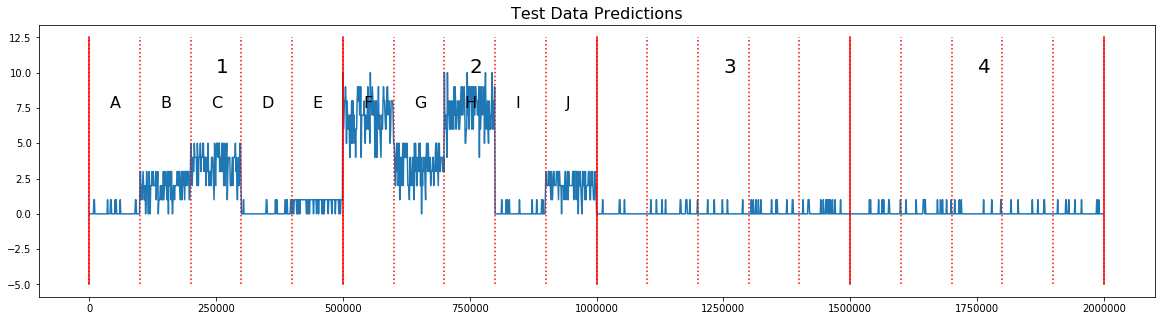

In [10]:
if PREDICT:
    ### preprocess
    # REMOVE BATCH 1 DRIFT
    start=500
    a = 0; b = 100000
    df_test.loc[df_test.index[a:b],'signal'] = df_test.signal.values[a:b] - 3*(df_test.time.values[a:b]-start)/10.
    start=510
    a = 100000; b = 200000
    df_test.loc[df_test.index[a:b],'signal'] = df_test.signal.values[a:b] - 3*(df_test.time.values[a:b]-start)/10.
    start=540
    a = 400000; b = 500000
    df_test.loc[df_test.index[a:b],'signal'] = df_test.signal.values[a:b] - 3*(df_test.time.values[a:b]-start)/10.
    # REMOVE BATCH 2 DRIFT
    start=560
    a = 600000; b = 700000
    df_test.loc[df_test.index[a:b],'signal'] = df_test.signal.values[a:b] - 3*(df_test.time.values[a:b]-start)/10.
    start=570
    a = 700000; b = 800000
    df_test.loc[df_test.index[a:b],'signal'] = df_test.signal.values[a:b] - 3*(df_test.time.values[a:b]-start)/10.
    start=580
    a = 800000; b = 900000
    df_test.loc[df_test.index[a:b],'signal'] = df_test.signal.values[a:b] - 3*(df_test.time.values[a:b]-start)/10.
    # REMOVE BATCH 3 DRIFT
    def f(x):
        return -(0.00788)*(x-625)**2+2.345 +2.58
    a = 1000000; b = 1500000
    df_test.loc[df_test.index[a:b],'signal'] = df_test.signal.values[a:b] - f(df_test.time[a:b].values)
    
    ## predict
    sub = pd.read_csv("../input/liverpool-ion-switching/sample_submission.csv", dtype={'time':str})

    predictors = {}
    for num_classes, model_name in zip(
            np.array([1, 1, 3, 5, 10])+1,
            ['1s', '1f', '3', '5', '10']
        ):
        
        if not ENSEMBLE:
            models = [Unet(num_classes=num_classes),]
            predictor = Predictor(device, models)
            predictor.load_checkpoint(os.path.join(workspace, f"{model_name}_best.pth.tar"), 0)
        else:
            # ensemble happens here
            models = [
                    Unet(num_classes=num_classes),
                    #Unet(num_classes=num_classes),
                    #Unet(num_classes=num_classes),
                    #Unet(num_classes=num_classes),
                    #Unet(num_classes=num_classes),
                ]
            predictor = Predictor(device, models)
            predictor.load_checkpoint(os.path.join("workspace/unet-wide-4k-f0", f"{model_name}_best.pth.tar"), 0)
            #predictor.load_checkpoint(os.path.join("workspace/unet-wide-4k-f1", f"{model_name}_best.pth.tar"), 1)
            #predictor.load_checkpoint(os.path.join("workspace/unet-4k-f2", f"{model_name}_best.pth.tar"), 2)
            #predictor.load_checkpoint(os.path.join("workspace/unet-4k-f3", f"{model_name}_best.pth.tar"), 3)
            #predictor.load_checkpoint(os.path.join("workspace/unet-4k-f4", f"{model_name}_best.pth.tar"), 4)

        predictors[model_name] = predictor

    for start, end, model_type in zip(
            np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])*100000,
            np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20])*100000,
            ['1s', '3', '5', '1s', '1f', '10', '5', '10', '1s', '3', '1s'],
        ):
        X = df_test.signal.values[start:end].reshape(-1, 1, time_step_test)
        test_dataset = IonDataset(X, type='test')
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        res = predictors[model_type].predict(test_loader)
        sub.iloc[start:end,1] = res


    #sub.to_csv(os.path.join(workspace, "pred.csv"), index=False)
    sub.to_csv("pred.csv", index=False)
    
    
    plt.figure(figsize=(20,5))
    res = 1000
    let = ['A','B','C','D','E','F','G','H','I','J']
    plt.plot(range(0,df_test.shape[0],res),sub.open_channels[0::res])
    for i in range(5): plt.plot([i*500000,i*500000],[-5,12.5],'r')
    for i in range(21): plt.plot([i*100000,i*100000],[-5,12.5],'r:')
    for k in range(4): plt.text(k*500000+250000,10,str(k+1),size=20)
    for k in range(10): plt.text(k*100000+40000,7.5,let[k],size=16)
    plt.title('Test Data Predictions',size=16)
    plt.show()
    